# Kaggle dataset extractor and organizer

In [3]:
import os

#os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/afons/.kaggle/'

import zipfile
import pandas as pd
import kaggle
from docx import Document

### Remove feather files, if they exist

In [9]:
data_folder = 'data'

# List all files in the data folder
files = os.listdir(data_folder)

# Remove Feather files (files with a ".feather" extension)
for file in files:
    if file.endswith(".feather"):
        file_path = os.path.join(data_folder, file)
        os.remove(file_path)
        print(f"Removed {file_path}")

print("Feather files removed from the 'data' folder.")

Removed data\Crime_Data_from_2010_to_2019_0.feather
Removed data\Crime_Data_from_2010_to_2019_1.feather
Removed data\Crime_Data_from_2010_to_2019_2.feather
Removed data\Crime_Data_from_2010_to_2019_3.feather
Removed data\Crime_Data_from_2010_to_2019_4.feather
Removed data\Crime_Data_from_2010_to_2019_5.feather
Removed data\Crime_Data_from_2010_to_2019_6.feather
Removed data\Crime_Data_from_2010_to_2019_7.feather
Removed data\Crime_Data_from_2010_to_2019_8.feather
Removed data\Crime_Data_from_2010_to_2019_9.feather
Removed data\Crime_Data_from_2020_to_Present.feather
Feather files removed from the 'data' folder.


## Download the kaggle dataset

In [10]:
# set the path to the dataset on Kaggle
dataset_path = 'sumaiaparveenshupti/los-angeles-crime-data-20102020'

# download the dataset to the data folder
kaggle.api.dataset_download_files(dataset_path, path='data')


## Extract the files from zip, get into feather files and remove csv and zip file

In [11]:

# set the path to the zip file
zip_path = 'data/los-angeles-crime-data-20102020.zip'

# extract all csv files from the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

In [12]:
import csv
import os

# Create the "data" directory if it doesn't exist
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Specify the input CSV file and the number of partitions
input_file = 'data/Crime_Data_from_2010_to_2019.csv'
num_partitions = 10  # Change this to the desired number of partitions

# Initialize a list of output CSV writers and files
output_writers = []
output_files = []

# Open the input file
with open(input_file, 'r') as input_csv:
    # Create a CSV reader for the input file
    csv_reader = csv.reader(input_csv)

    # Read the CSV header
    header = next(csv_reader)

    # Open output CSV files and writers for each partition in the "data" directory
    for i in range(num_partitions):
        partition_file = os.path.join(data_dir, f'Crime_Data_from_2010_to_2019_{i}.csv')
        output_file = open(partition_file, 'w', newline='')
        output_files.append(output_file)
        output_writers.append(csv.writer(output_file))

        # Write the header to each output file
        output_writers[i].writerow(header)

    # Iterate through the input CSV and distribute rows to output partitions
    current_partition = 0
    for row in csv_reader:
        output_writers[current_partition].writerow(row)
        current_partition = (current_partition + 1) % num_partitions  # Cycle through partitions

# Close all output CSV files
for output_file in output_files:
    output_file.close()

print(f'Partitioned into {num_partitions} smaller CSV files in the "data" folder.')


Partitioned into 10 smaller CSV files in the "data" folder.


In [13]:
# iterate over all csv files in the data folder
for file_name in os.listdir('data'):
    if file_name.endswith('.csv'):
        print(f'Processing {file_name}...')
        # read the csv file into a pandas dataframe
        df = pd.read_csv(os.path.join('data', file_name))
        
        # transform the dataframe into more space-efficient datatypes
        for col in df.columns:
            if df[col].dtype == 'int64':
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif df[col].dtype == 'float64':
                df[col] = pd.to_numeric(df[col], downcast='float')
        
        # save the transformed dataframe as a feather file
        feather_path = os.path.join('data', os.path.splitext(file_name)[0] + '.feather')
        df.to_feather(feather_path)

Processing Crime_Data_from_2010_to_2019.csv...
Processing Crime_Data_from_2010_to_2019_0.csv...
Processing Crime_Data_from_2010_to_2019_1.csv...
Processing Crime_Data_from_2010_to_2019_2.csv...
Processing Crime_Data_from_2010_to_2019_3.csv...
Processing Crime_Data_from_2010_to_2019_4.csv...
Processing Crime_Data_from_2010_to_2019_5.csv...
Processing Crime_Data_from_2010_to_2019_6.csv...
Processing Crime_Data_from_2010_to_2019_7.csv...
Processing Crime_Data_from_2010_to_2019_8.csv...
Processing Crime_Data_from_2010_to_2019_9.csv...
Processing Crime_Data_from_2020_to_Present.csv...


In [14]:
# delete the zip file and the csv files
os.remove('data/los-angeles-crime-data-20102020.zip')
for file_name in os.listdir('data'):
    if file_name.endswith('.csv'):
        os.remove(os.path.join('data', file_name))
os.remove('data/Crime_Data_from_2010_to_2019.feather')

### Folder size

In [15]:
def get_folder_size(path):
    total_size = 0

    # Walk through the directory tree and add up the sizes of all files and subdirectories
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)

    return total_size

# Specify the path to the folder you want to measure
folder_path = 'data'

# Get the folder size in bytes
size_in_bytes = get_folder_size(folder_path)

# Convert the size to a more human-readable format (e.g., MB, GB)
def convert_bytes_to_readable(size_in_bytes):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_in_bytes < 1024.0:
            break
        size_in_bytes /= 1024.0
    return f"{size_in_bytes:.2f} {unit}"

folder_size_readable = convert_bytes_to_readable(size_in_bytes)

print(f"The folder size is: {folder_size_readable}")

The folder size is: 247.90 MB


## Spread the feathers into dataframes, after merging

In [4]:
cd1 = pd.read_feather('data/Crime_Data_from_2010_to_2019_0.feather')
cd2 = pd.read_feather('data/Crime_Data_from_2010_to_2019_1.feather')
cd3 = pd.read_feather('data/Crime_Data_from_2010_to_2019_2.feather')
cd4 = pd.read_feather('data/Crime_Data_from_2010_to_2019_3.feather')
cd5 = pd.read_feather('data/Crime_Data_from_2010_to_2019_4.feather')
cd6 = pd.read_feather('data/Crime_Data_from_2010_to_2019_5.feather')
cd7 = pd.read_feather('data/Crime_Data_from_2010_to_2019_6.feather')
cd8 = pd.read_feather('data/Crime_Data_from_2010_to_2019_7.feather')
cd9 = pd.read_feather('data/Crime_Data_from_2010_to_2019_8.feather')
cd10 = pd.read_feather('data/Crime_Data_from_2010_to_2019_9.feather')
#cd11 = pd.read_feather('data/Crime_Data_from_2020_to_Present.feather')
MoCodes = pd.read_csv('data/MO_CODES_Numerical_20180627.csv', dtype={'MoCode': str})

cd = pd.concat([cd1, cd2, cd3, cd4, cd5, cd6, cd7, cd8, cd9, cd10], axis=0)

cd.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [5]:
cd = cd.rename(columns={'Date Rptd': 'DateRptd', 'DATE OCC': 'DateOcc', 'TIME OCC': 'TimeOcc', 'AREA ': 'Area' ,'AREA NAME': 'AreaName', 'Crm Cd': 'CrmCd', 'Crm Cd Desc': 'CrmCdDesc', 'Status Desc': 'StatusDesc', 'Rpt Dist No': 'RptDistNo', 'Vict Age': 'VictAge', 'Vict Sex': 'VictSex', 'Vict Descent': 'VictDescent', 'Weapon Used Cd': 'WpnCd', 'Weapon Desc': 'WpnDesc'})

MoCodes.head()
print(cd.iloc[0, cd.columns.get_loc('Mocodes')])

0913 1814 2000


In [6]:
cdc = cd[['DR_NO','CrmCd', 'CrmCdDesc', 'Status', 'StatusDesc']]
cdd = cd[['DR_NO', 'DateRptd', 'DateOcc', 'TimeOcc']]
cda = cd[['DR_NO', 'Area', 'AreaName', 'RptDistNo', 'LOCATION', 'LAT', 'LON']]
cdv = cd[['DR_NO', 'VictAge', 'VictSex', 'VictDescent']]
cdp = cd[['DR_NO', 'Premis Cd', 'Premis Desc']]
cdw = cd[['DR_NO', 'WpnCd', 'WpnDesc']]
cdm = cd[['DR_NO', 'Mocodes']]
cmd2 = cdm.copy()

### MAPING MOCODE TO DESCRIPTION

In [7]:
mo_code_mapping = dict(zip(MoCodes['MoCode'], MoCodes['Description']))

cdm['MoDesc'] = cdm['Mocodes'].apply(lambda x: '; '.join(mo_code_mapping.get(str(code), '') for code in str(x).split()))

cdm.head()

C:\Users\afons\AppData\Local\Temp\ipykernel_13344\3217841030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdm['MoDesc'] = cdm['Mocodes'].apply(lambda x: '; '.join(mo_code_mapping.get(str(code), '') for code in str(x).split()))


,DR_NO,Mocodes,MoDesc
0,1307355,0913 1814 2000,Victim knew Suspect; Susp is/was current/forme...
1,100100521,0400 0429 2000,Force used; Vict knocked to ground; Domestic v...
2,100100562,0416 2000,Hit-Hit w/ weapon; Domestic violence
3,100100581,0400 0417,Force used; Kicked
4,100100628,0408,Choked/uses choke hold/Strangulation/Suffocation


Since we have the joined dataframe, we can run the full EDA on there.

### DATES TO SQLITE FRIENDLY FORMAT 

In [8]:
cdd['TimeOcc'] = cdd['TimeOcc'].astype(str).str.zfill(4).str[:2] + ':' + cdd['TimeOcc'].astype(str).str.zfill(4).str[2:]


cdd.head()

C:\Users\afons\AppData\Local\Temp\ipykernel_13344\2659701755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd['TimeOcc'] = cdd['TimeOcc'].astype(str).str.zfill(4).str[:2] + ':' + cdd['TimeOcc'].astype(str).str.zfill(4).str[2:]


,DR_NO,DateRptd,DateOcc,TimeOcc
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,13:50
1,100100521,01/14/2010 12:00:00 AM,01/14/2010 12:00:00 AM,14:45
2,100100562,01/28/2010 12:00:00 AM,01/28/2010 12:00:00 AM,23:45
3,100100581,02/05/2010 12:00:00 AM,02/05/2010 12:00:00 AM,14:25
4,100100628,02/15/2010 12:00:00 AM,02/14/2010 12:00:00 AM,15:00


In [9]:
cdd['DateRptd'] = pd.to_datetime(cdd['DateRptd'], format='%m/%d/%Y %I:%M:%S %p')
cdd['DateRptd'] = cdd['DateRptd'].dt.strftime('%Y-%m-%d')
cdd['DateOcc'] = pd.to_datetime(cdd['DateOcc'], format='%m/%d/%Y %I:%M:%S %p')

cdd.head()

C:\Users\afons\AppData\Local\Temp\ipykernel_13344\1798381014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd['DateRptd'] = pd.to_datetime(cdd['DateRptd'], format='%m/%d/%Y %I:%M:%S %p')
C:\Users\afons\AppData\Local\Temp\ipykernel_13344\1798381014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd['DateRptd'] = cdd['DateRptd'].dt.strftime('%Y-%m-%d')
C:\Users\afons\AppData\Local\Temp\ipykernel_13344\1798381014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,DR_NO,DateRptd,DateOcc,TimeOcc
0,1307355,2010-02-20,2010-02-20,13:50
1,100100521,2010-01-14,2010-01-14,14:45
2,100100562,2010-01-28,2010-01-28,23:45
3,100100581,2010-02-05,2010-02-05,14:25
4,100100628,2010-02-15,2010-02-14,15:00


In [10]:
cdd['TimeOcc'] = pd.to_datetime(cdd['TimeOcc'], format='%H:%M').dt.time
cdd.head()


C:\Users\afons\AppData\Local\Temp\ipykernel_13344\3072541568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd['TimeOcc'] = pd.to_datetime(cdd['TimeOcc'], format='%H:%M').dt.time


,DR_NO,DateRptd,DateOcc,TimeOcc
0,1307355,2010-02-20,2010-02-20,13:50:00
1,100100521,2010-01-14,2010-01-14,14:45:00
2,100100562,2010-01-28,2010-01-28,23:45:00
3,100100581,2010-02-05,2010-02-05,14:25:00
4,100100628,2010-02-15,2010-02-14,15:00:00


In [11]:
cdd['DateOcc1'] = cdd['DateOcc'] + pd.to_timedelta(cdd['TimeOcc'].apply(lambda x: x.hour), unit='h') + pd.to_timedelta(cdd['TimeOcc'].apply(lambda x: x.minute), unit='m') + pd.to_timedelta(cdd['TimeOcc'].apply(lambda x: x.second), unit='s')

cdd.head()

C:\Users\afons\AppData\Local\Temp\ipykernel_13344\1566033866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd['DateOcc1'] = cdd['DateOcc'] + pd.to_timedelta(cdd['TimeOcc'].apply(lambda x: x.hour), unit='h') + pd.to_timedelta(cdd['TimeOcc'].apply(lambda x: x.minute), unit='m') + pd.to_timedelta(cdd['TimeOcc'].apply(lambda x: x.second), unit='s')


,DR_NO,DateRptd,DateOcc,TimeOcc,DateOcc1
0,1307355,2010-02-20,2010-02-20,13:50:00,2010-02-20 13:50:00
1,100100521,2010-01-14,2010-01-14,14:45:00,2010-01-14 14:45:00
2,100100562,2010-01-28,2010-01-28,23:45:00,2010-01-28 23:45:00
3,100100581,2010-02-05,2010-02-05,14:25:00,2010-02-05 14:25:00
4,100100628,2010-02-15,2010-02-14,15:00:00,2010-02-14 15:00:00


In [12]:
cdd['DateOcc'] = cdd['DateOcc1']

cdd.head()

cdd = cdd.drop(columns=['DateOcc1', 'TimeOcc'])

C:\Users\afons\AppData\Local\Temp\ipykernel_13344\3920342772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd['DateOcc'] = cdd['DateOcc1']


### CONVERT DATAFRAMES INTO SQL TABLES AND FEED DATA WAREHOUSE

In [6]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data/crimeDataWarehouse.db', echo=False)

cdc.to_sql('crimeMain', con=engine, if_exists='replace', index=False)
cdd.to_sql('crimeDate', con=engine, if_exists='replace', index=False)
cda.to_sql('crimeArea', con=engine, if_exists='replace', index=False)
cdv.to_sql('crimeVictim', con=engine, if_exists='replace', index=False)
cdp.to_sql('crimePremise', con=engine, if_exists='replace', index=False)
cdw.to_sql('crimeWeapon', con=engine, if_exists='replace', index=False)
cmd2.to_sql('crimeMo', con=engine, if_exists='replace', index=False)
MoCodes.to_sql('crimeMoMap', con=engine, if_exists='replace', index=False)

780

### DATAFRAMES INTO CSV

In [13]:
cmd2['Mocodes'] = cmd2['Mocodes'].fillna('0000')

cdc.to_csv('data/crimeMain.csv', index=False)
cdd.to_csv('data/crimeDate.csv', index=False)
cda.to_csv('data/crimeArea.csv', index=False)
cdv.to_csv('data/crimeVictim.csv', index=False)
cdp.to_csv('data/crimePremise.csv', index=False)
cdw.to_csv('data/crimeWeapon.csv', index=False)
cmd2.to_csv('data/crimeMo.csv', index=False)
MoCodes.to_csv('data/crimeMoMap.csv', index=False)

## EDA

### Importations needed

In [22]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium
from geopy.geocoders import Nominatim
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from wordcloud import WordCloud,STOPWORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import missingno as msno

### Show missing data

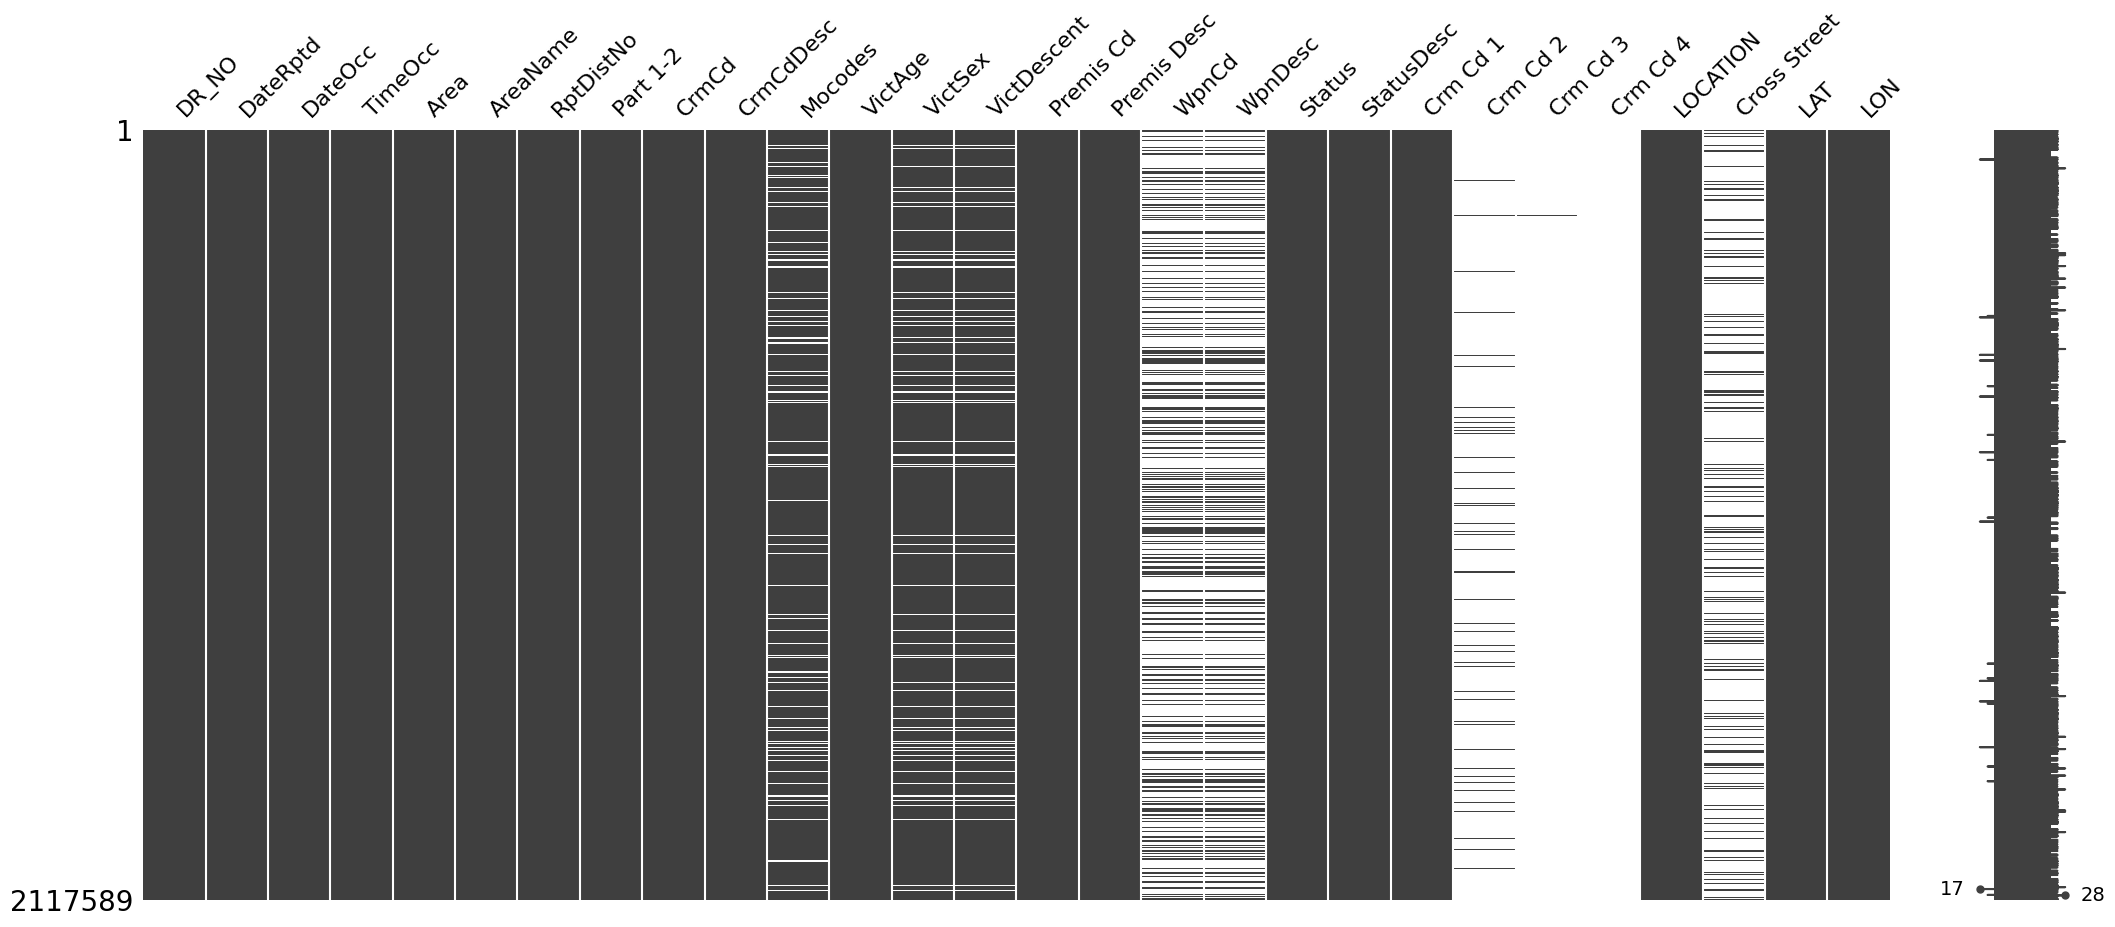

In [23]:
msno.matrix(cd)
plt.show()

We from this can justify cleaning the data a bit before resuming overall analysis

In [24]:
cd = cd.reset_index()
cd.drop(columns=['DR_NO', 'DateRptd','Part 1-2', 'Mocodes', 'Status', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street', 'index'],inplace=True)
cd.drop_duplicates(keep=False,inplace=True)

### Making datetime columns more presentable

In [25]:
cd['DateTimeValues'] = pd.to_datetime(cd['DateOcc'])
cd['year'] = cd['DateTimeValues'].dt.year
cd['month'] = cd['DateTimeValues'].dt.month
cd['day'] = cd['DateTimeValues'].dt.day

cd['TimeOcc'] = cd['TimeOcc'].astype(str).str.zfill(4)
cd['HOUR OCC'] = cd['TimeOcc'].apply(lambda t: int(t[:2]))

cd.info()

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\2130533186.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cd['DateTimeValues'] = pd.to_datetime(cd['DateOcc'])


<class 'pandas.core.frame.DataFrame'>
Index: 2104656 entries, 0 to 2117588
Data columns (total 24 columns):
 #   Column          Dtype         
---  ------          -----         
 0   DateOcc         object        
 1   TimeOcc         object        
 2   Area            int8          
 3   AreaName        object        
 4   RptDistNo       int16         
 5   CrmCd           int16         
 6   CrmCdDesc       object        
 7   VictAge         int8          
 8   VictSex         object        
 9   VictDescent     object        
 10  Premis Cd       float32       
 11  Premis Desc     object        
 12  WpnCd           float32       
 13  WpnDesc         object        
 14  StatusDesc      object        
 15  Crm Cd 1        float32       
 16  LOCATION        object        
 17  LAT             float32       
 18  LON             float32       
 19  DateTimeValues  datetime64[ns]
 20  year            int32         
 21  month           int32         
 22  day             int32  

### Correlations matrix

<Axes: >

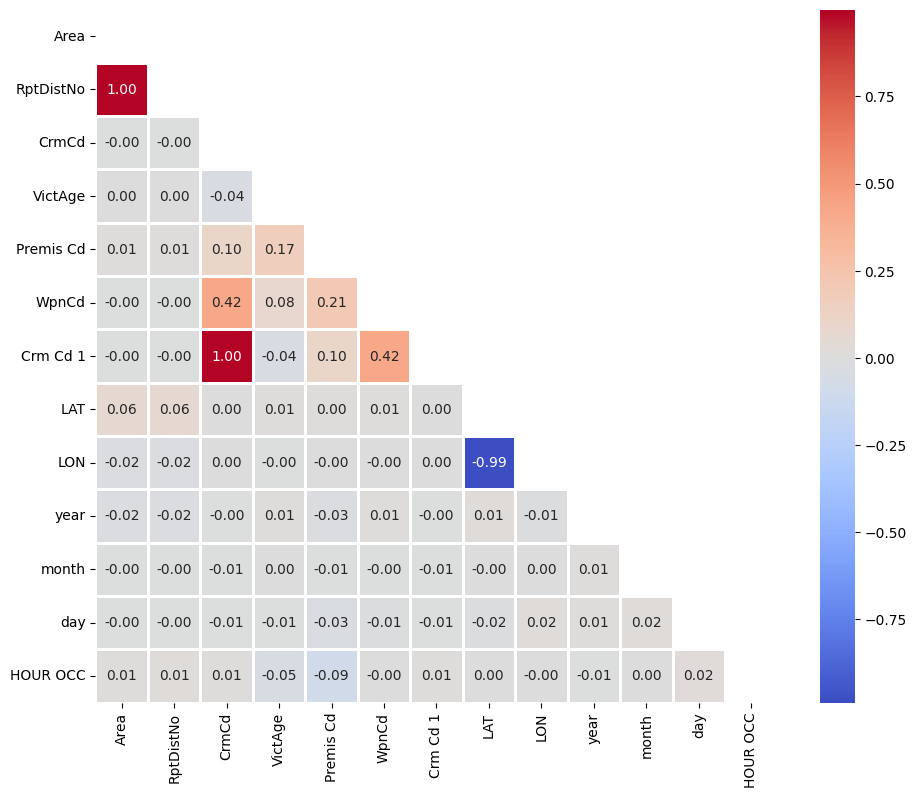

In [26]:
cd_num = cd.select_dtypes(include=np.number)

fig, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(cd_num.corr(), dtype=bool))

sns.heatmap(cd_num.corr(), mask=mask, cmap='coolwarm', center=0, linewidths=1, annot=True, fmt=".2f")

### NUMBER OF CRIMES PER AREA

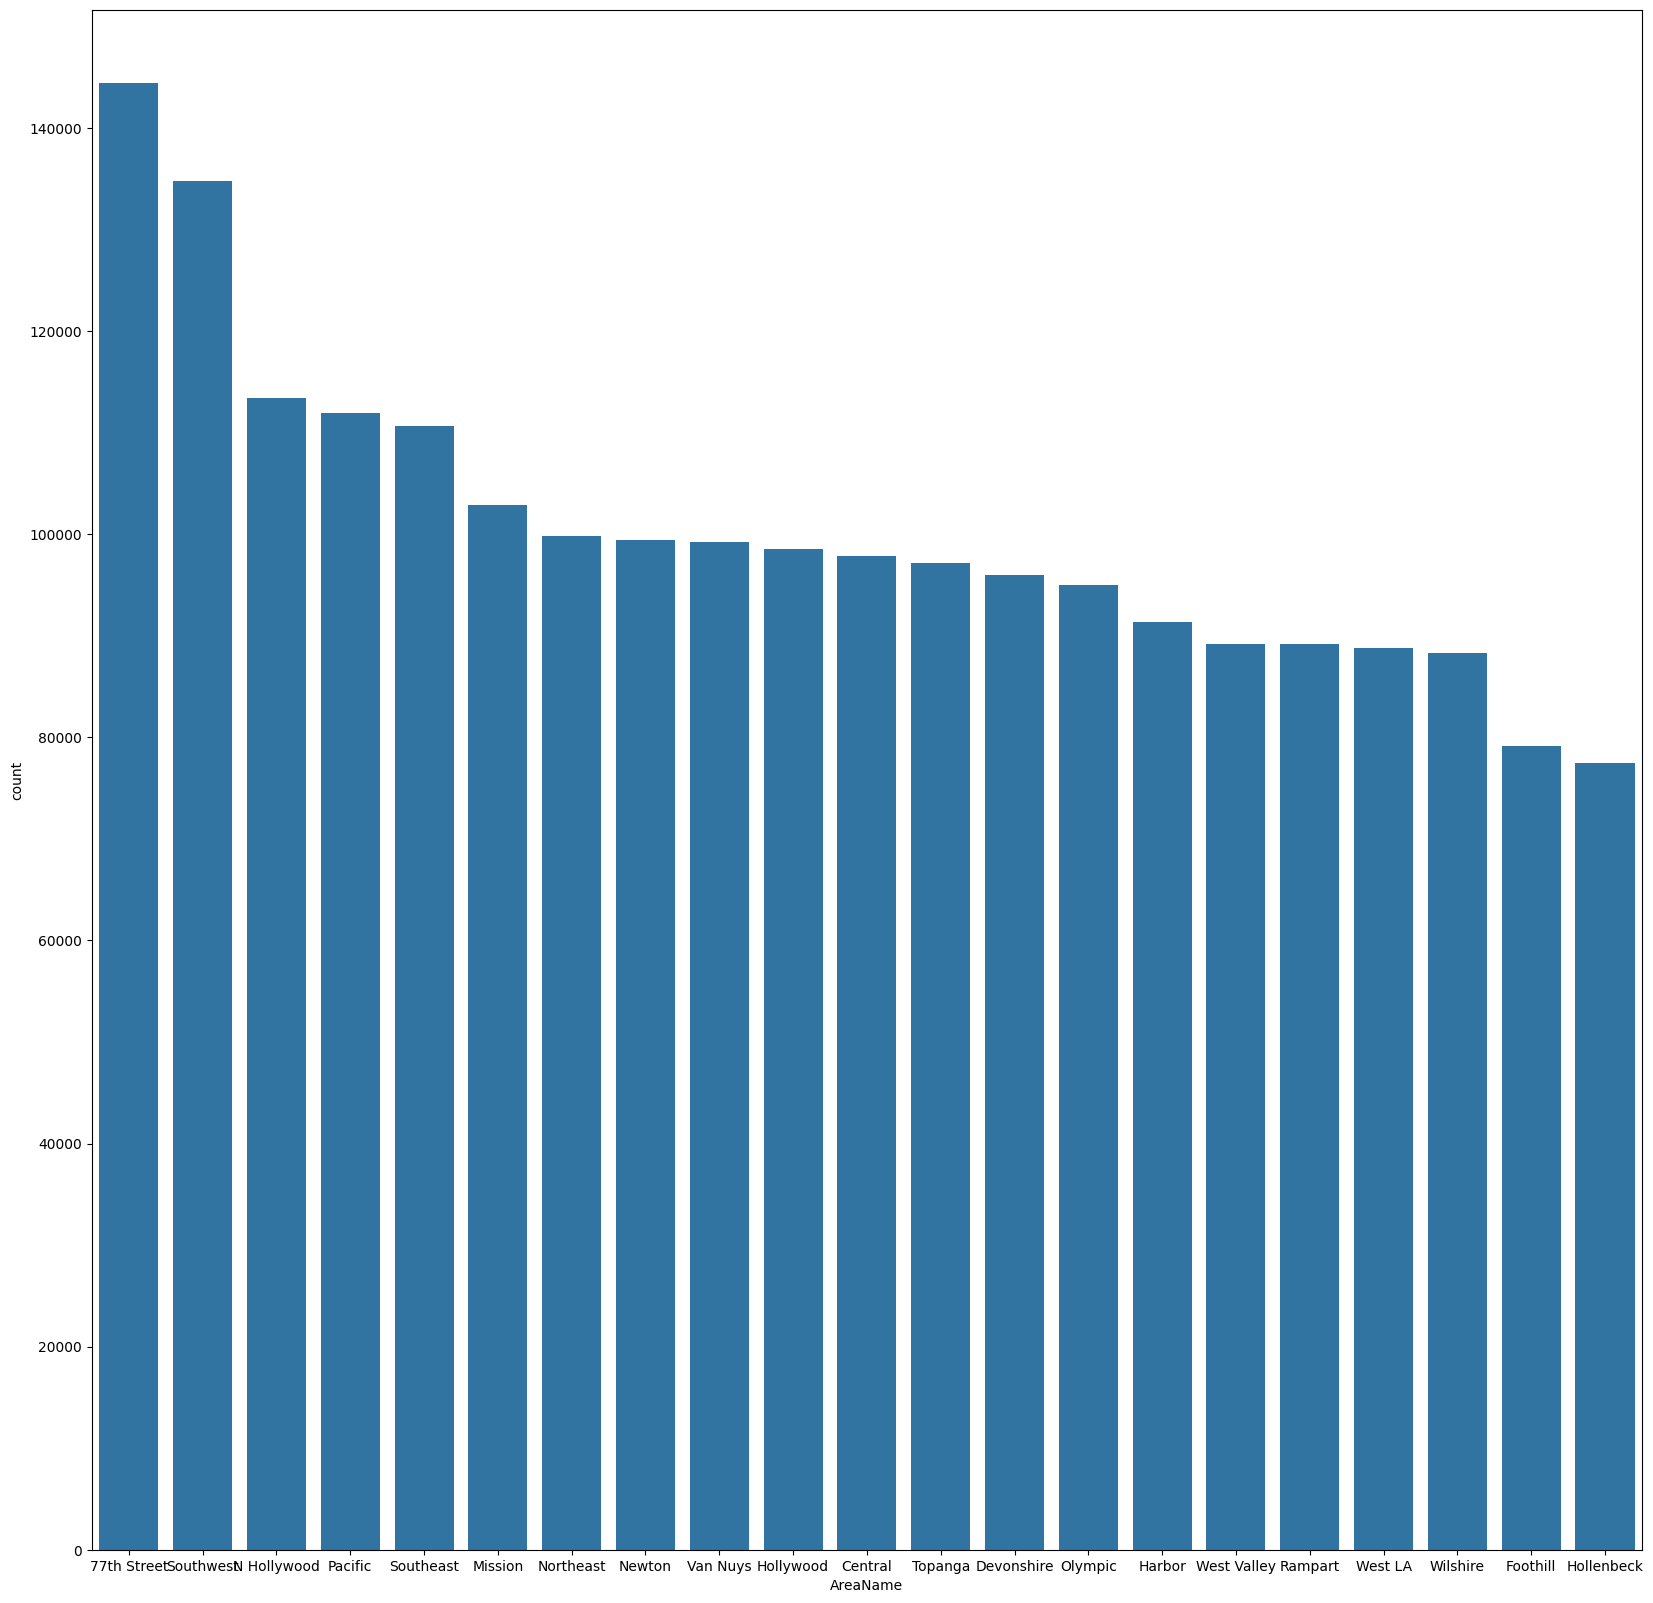

In [27]:
plt.figure(figsize=(20, 20))
sns.countplot(x="AreaName", data=cd, order=cd['AreaName'].value_counts().index)
plt.show()

### CRIME DESCRIPTIONS PER AREA

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


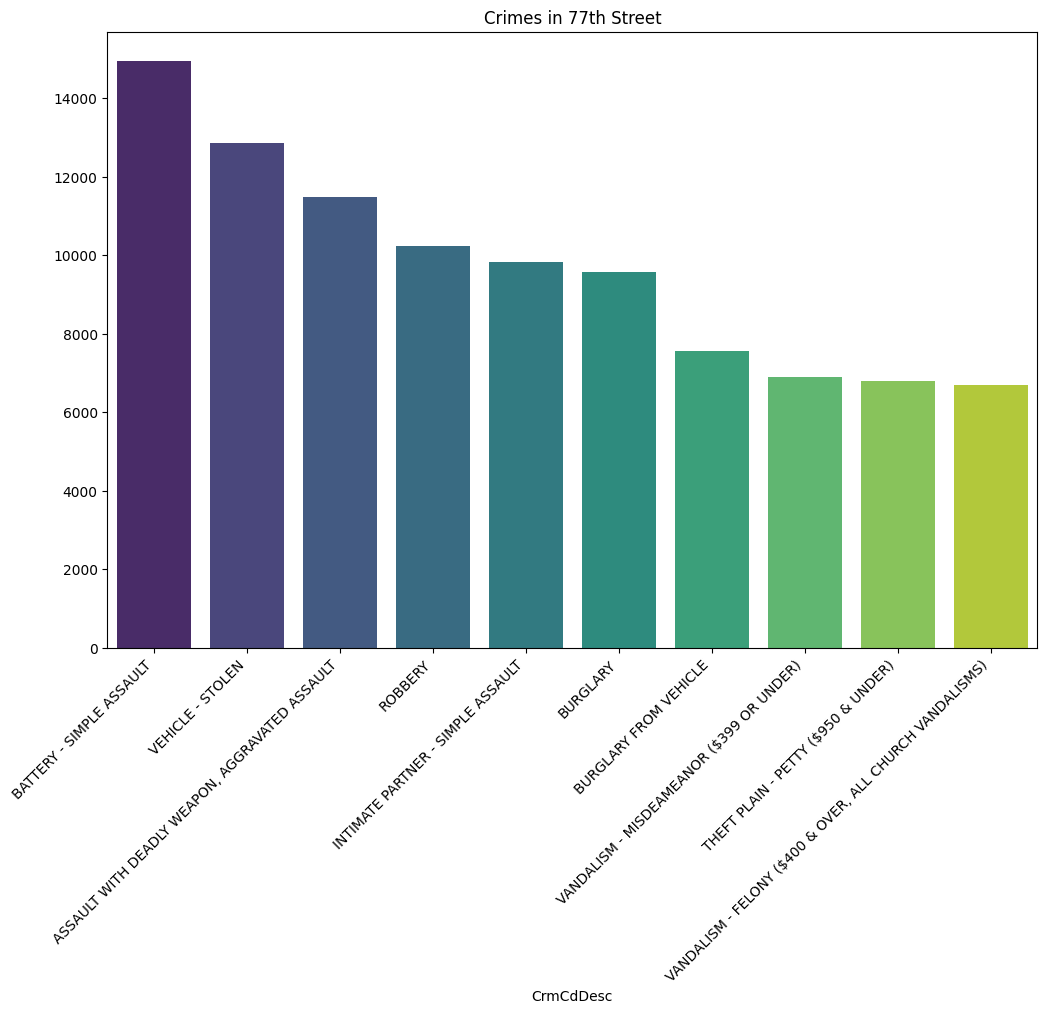

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


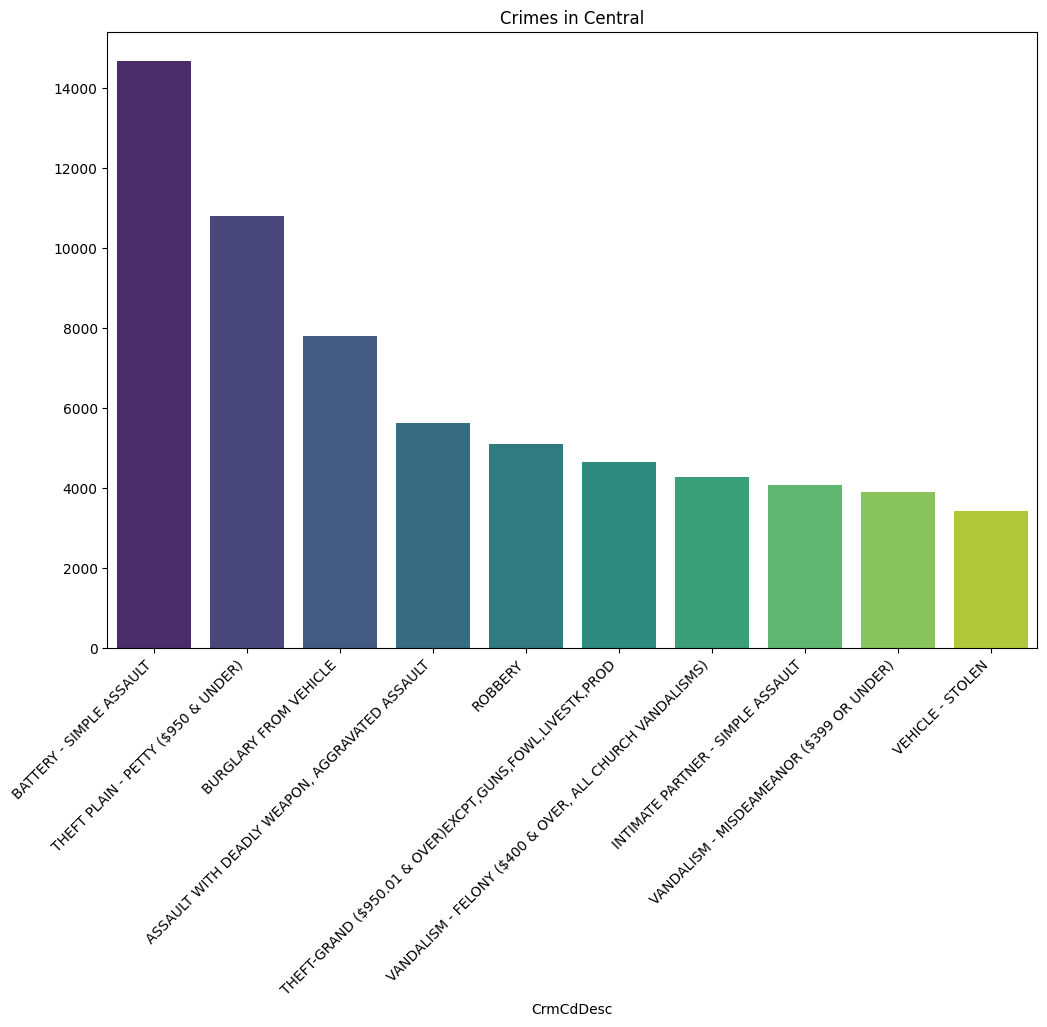

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


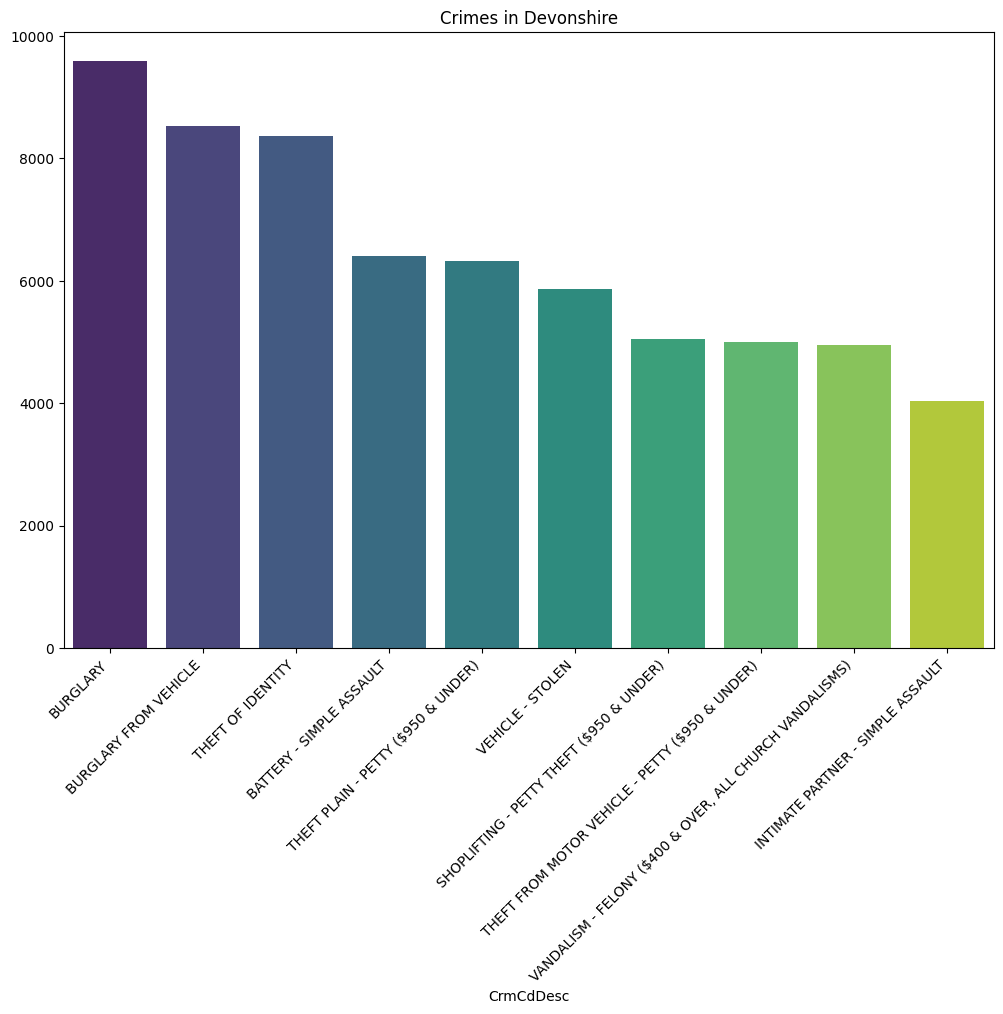

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


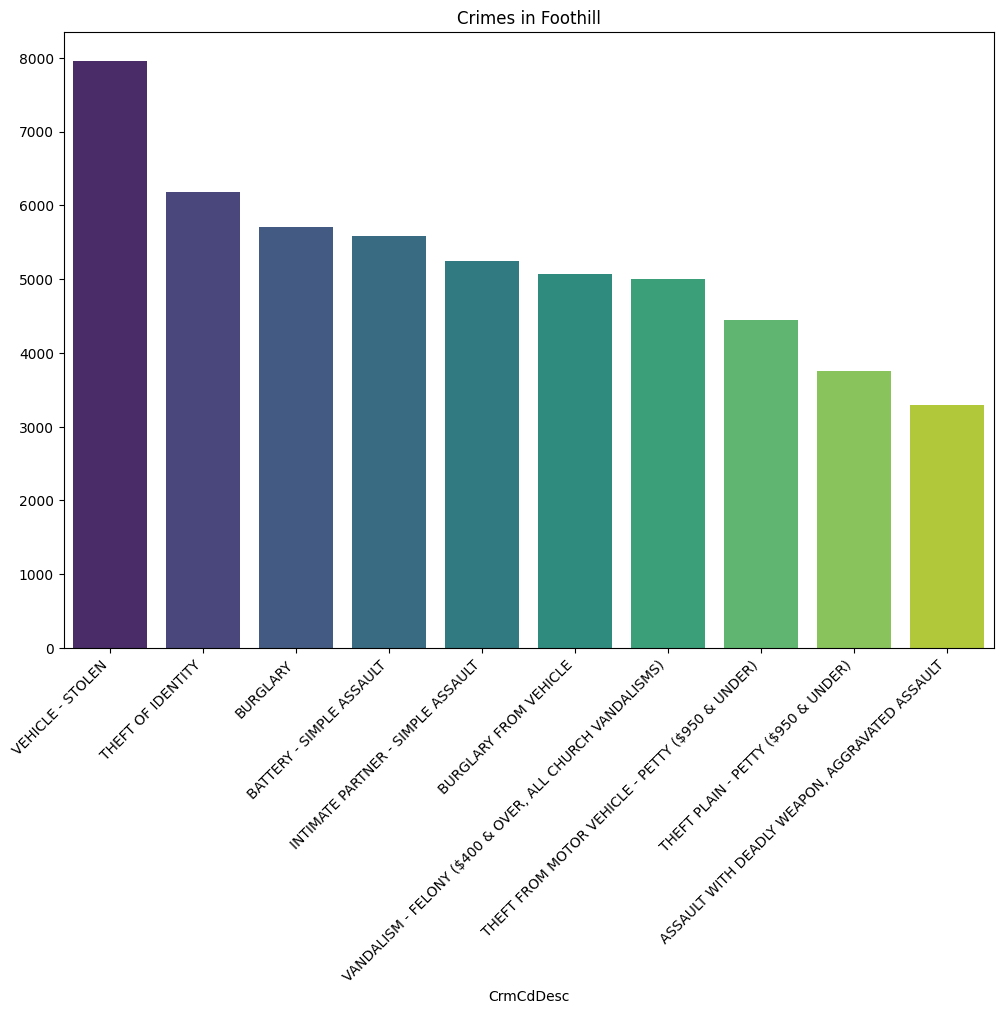

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


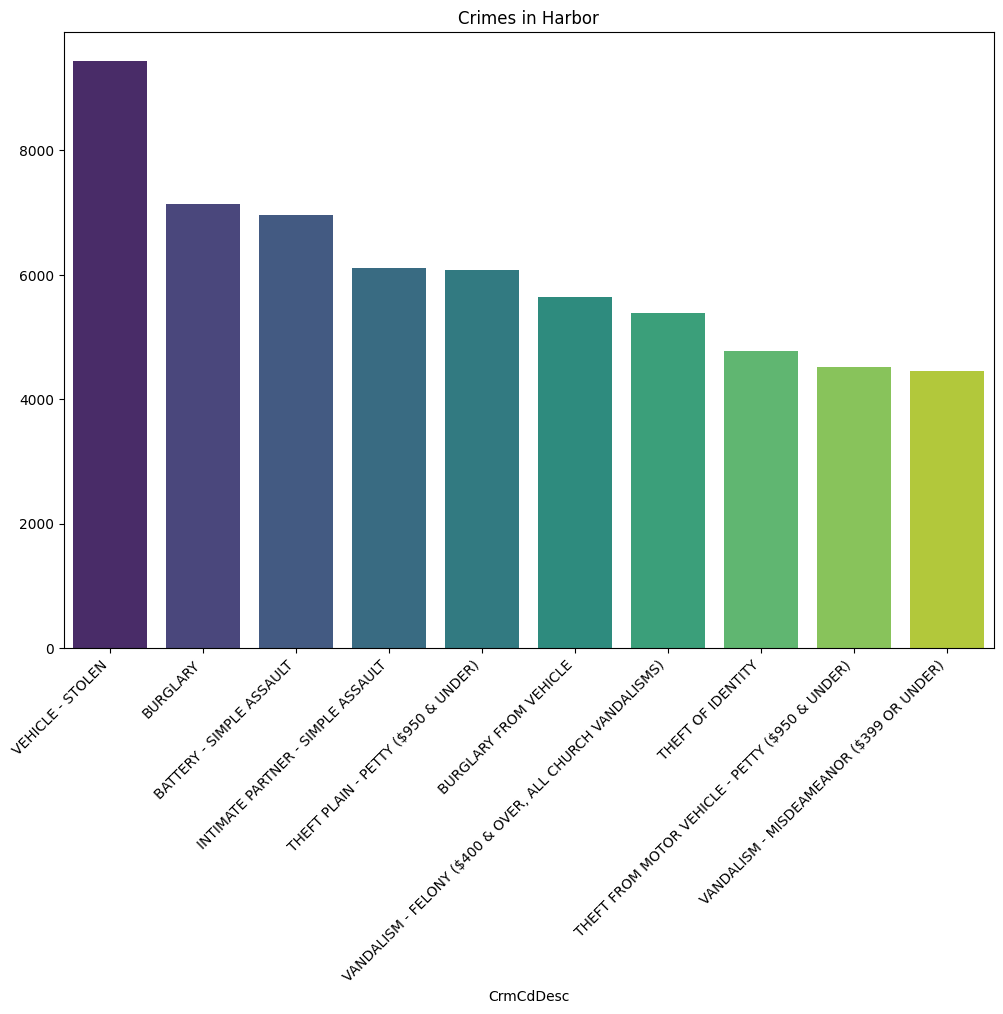

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


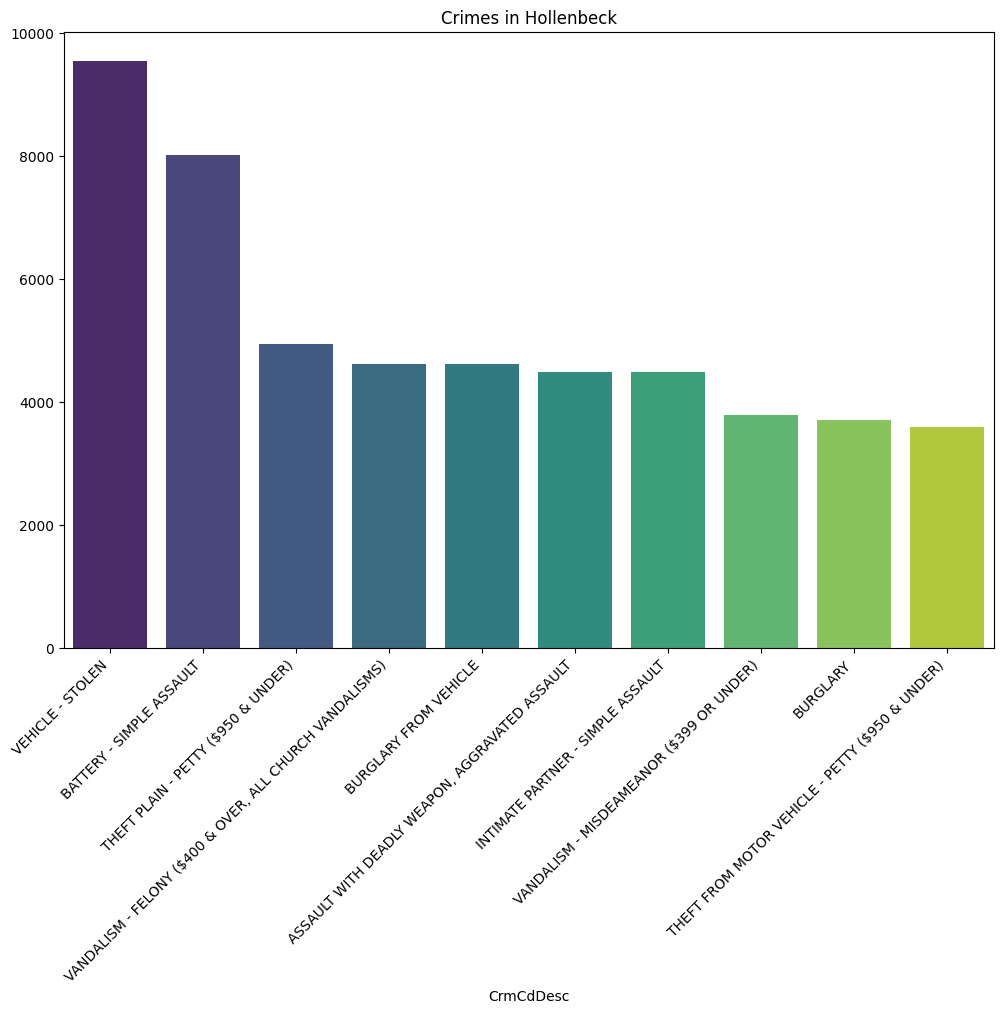

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


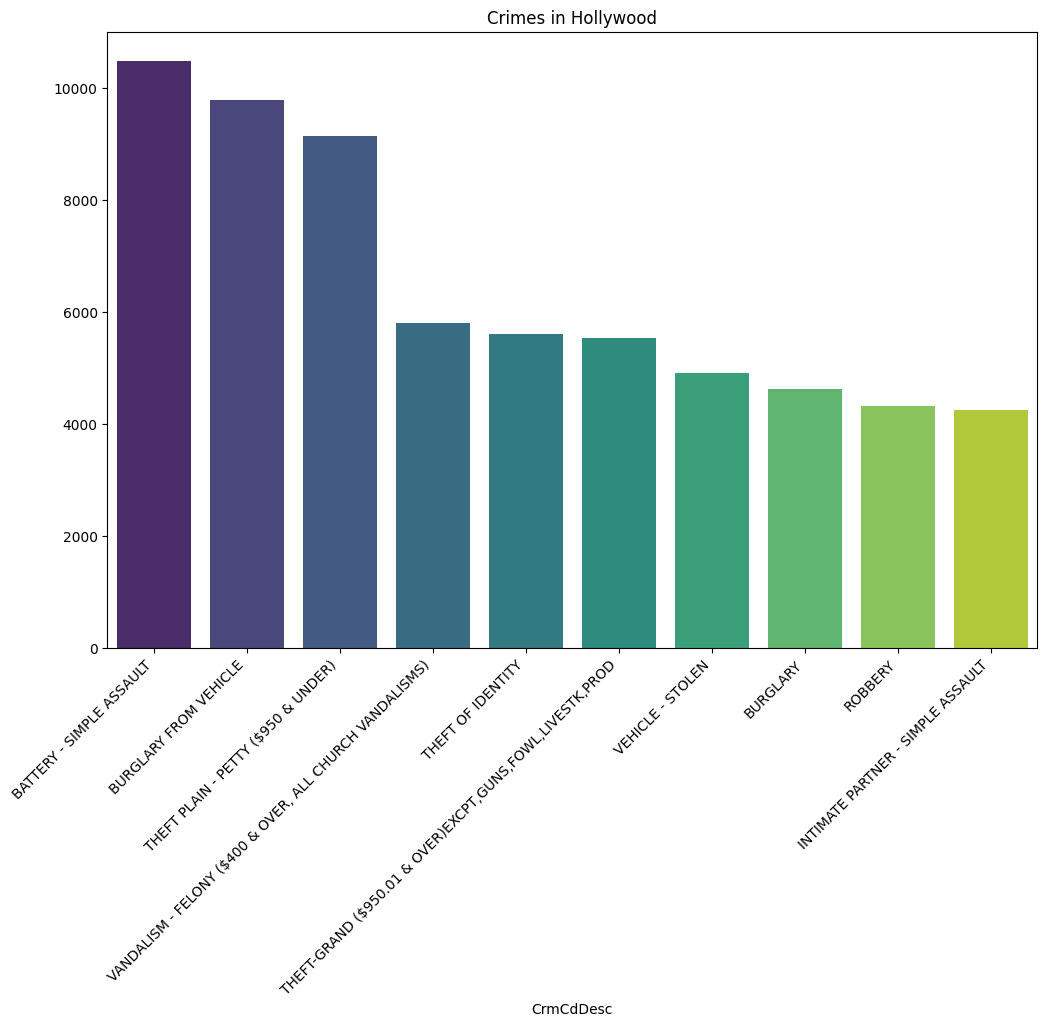

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


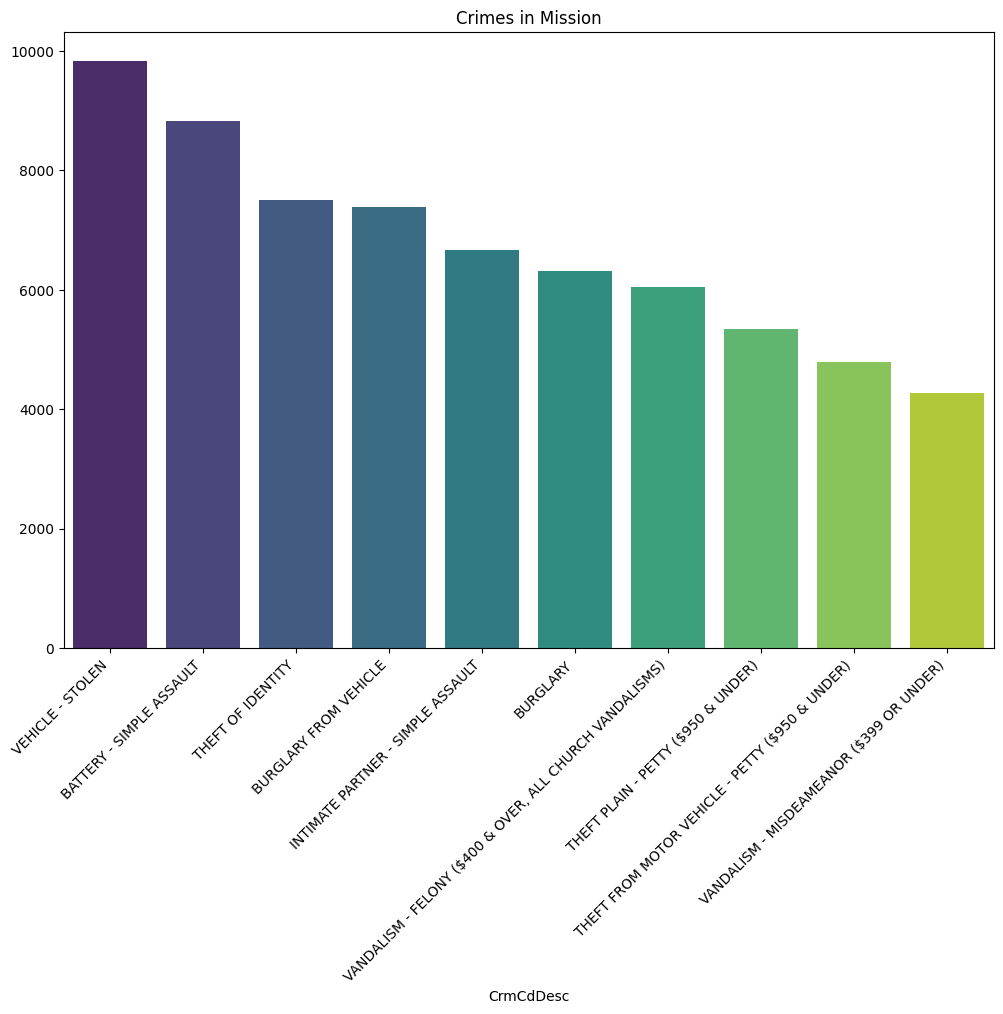

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


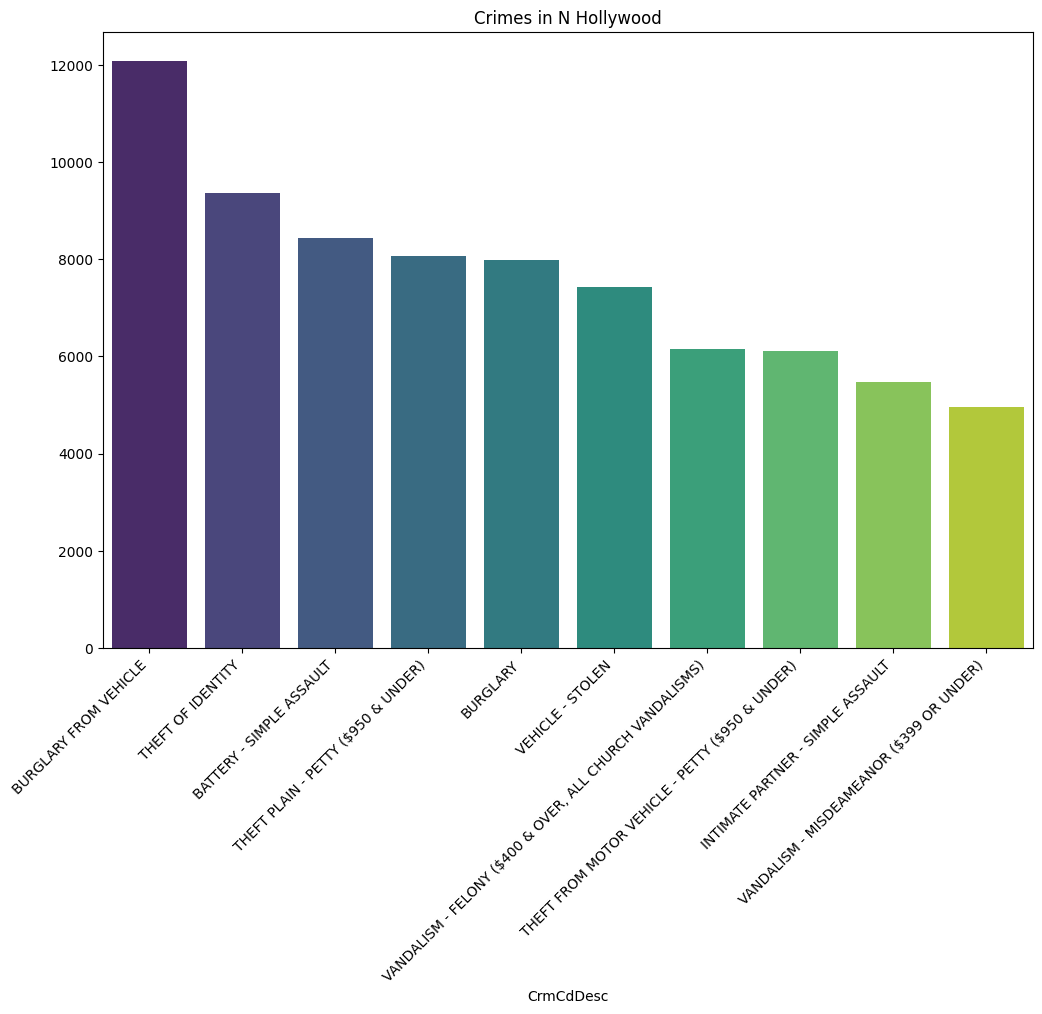

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


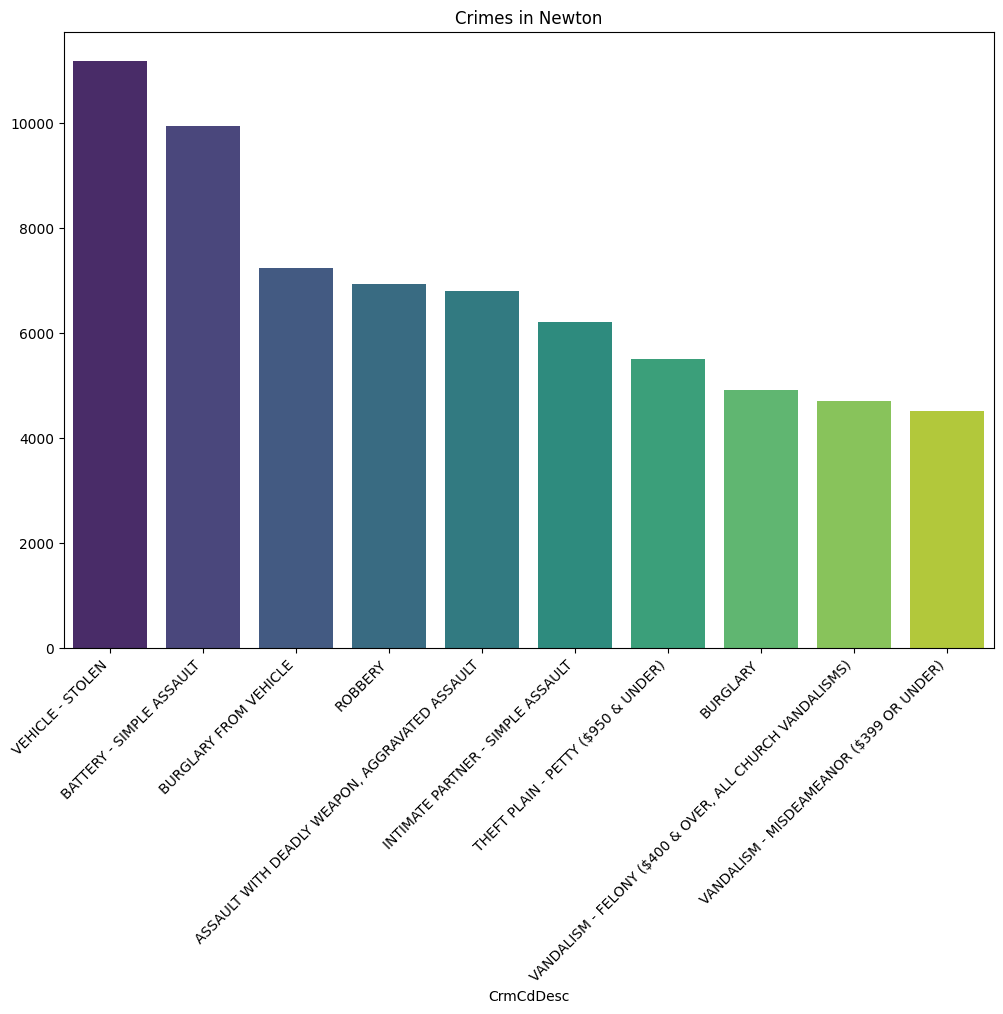

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


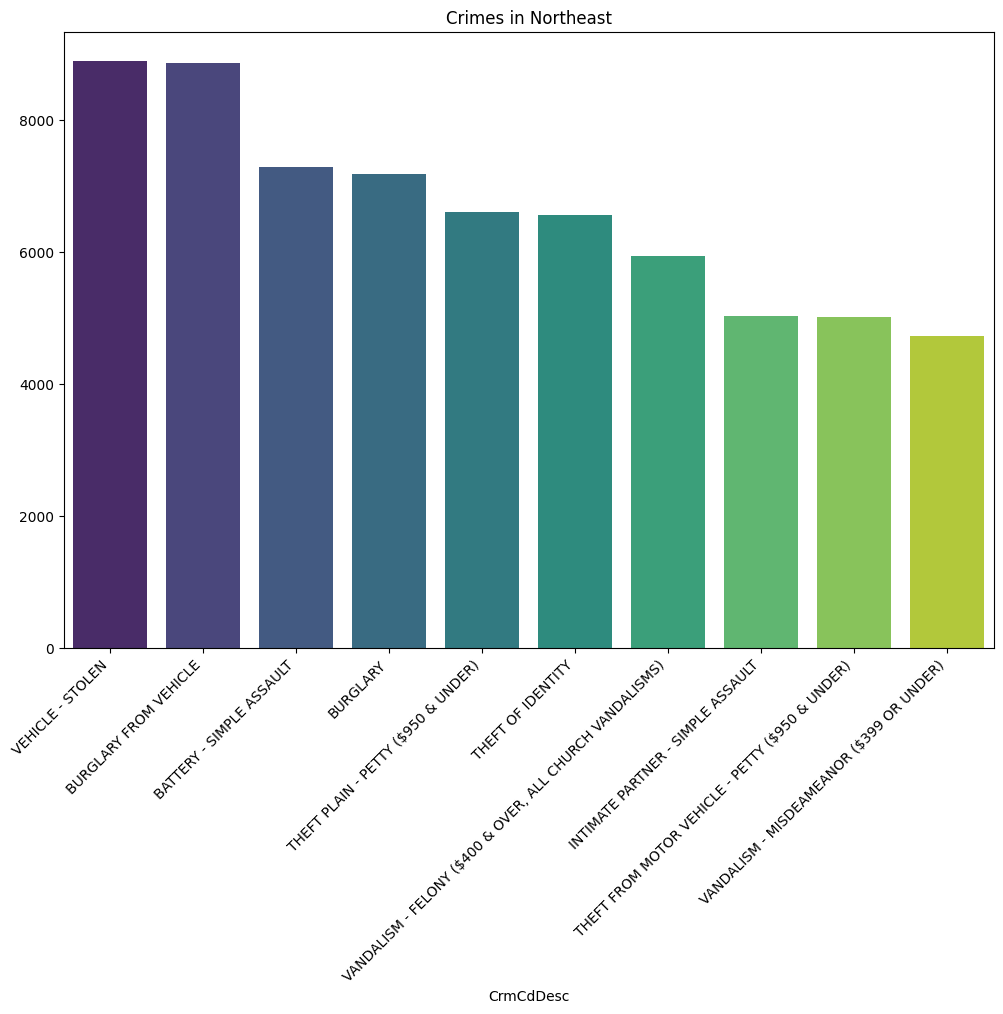

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


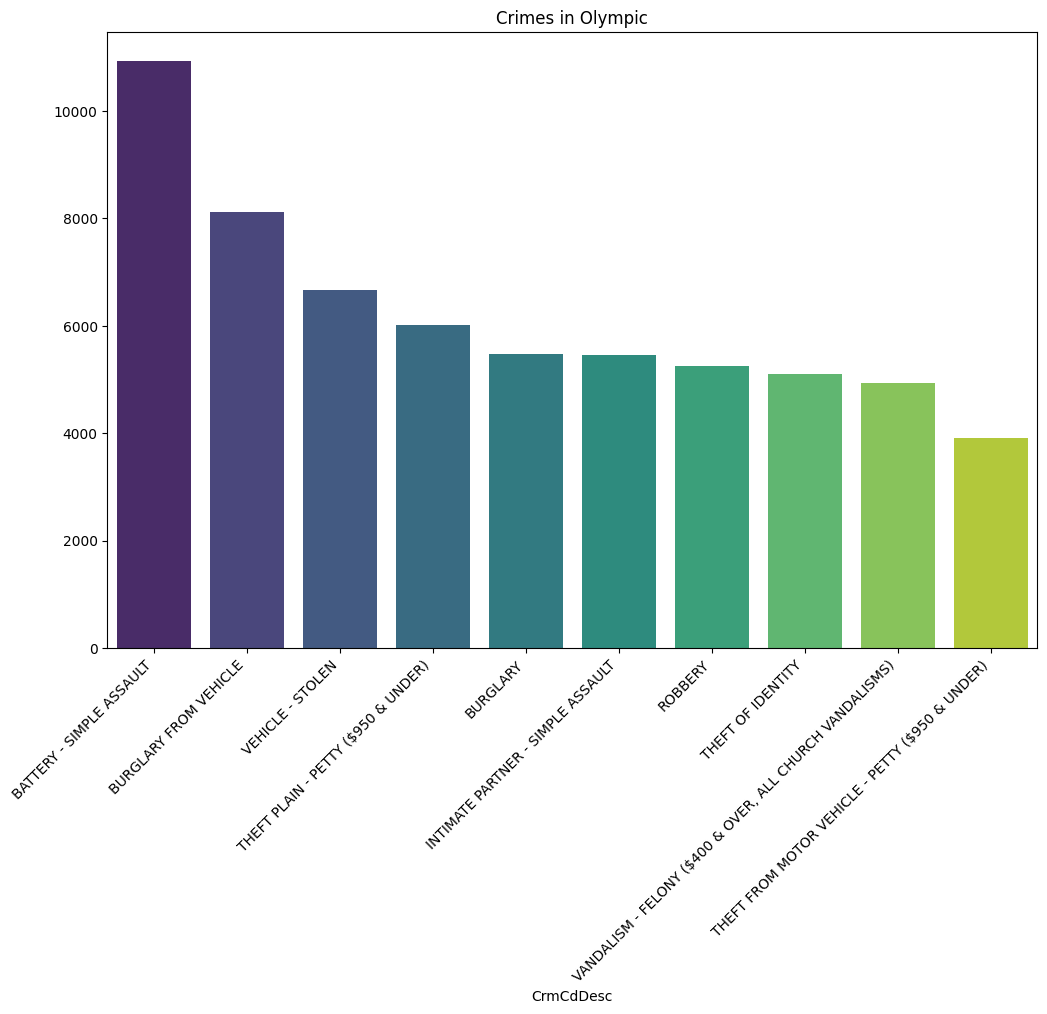

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


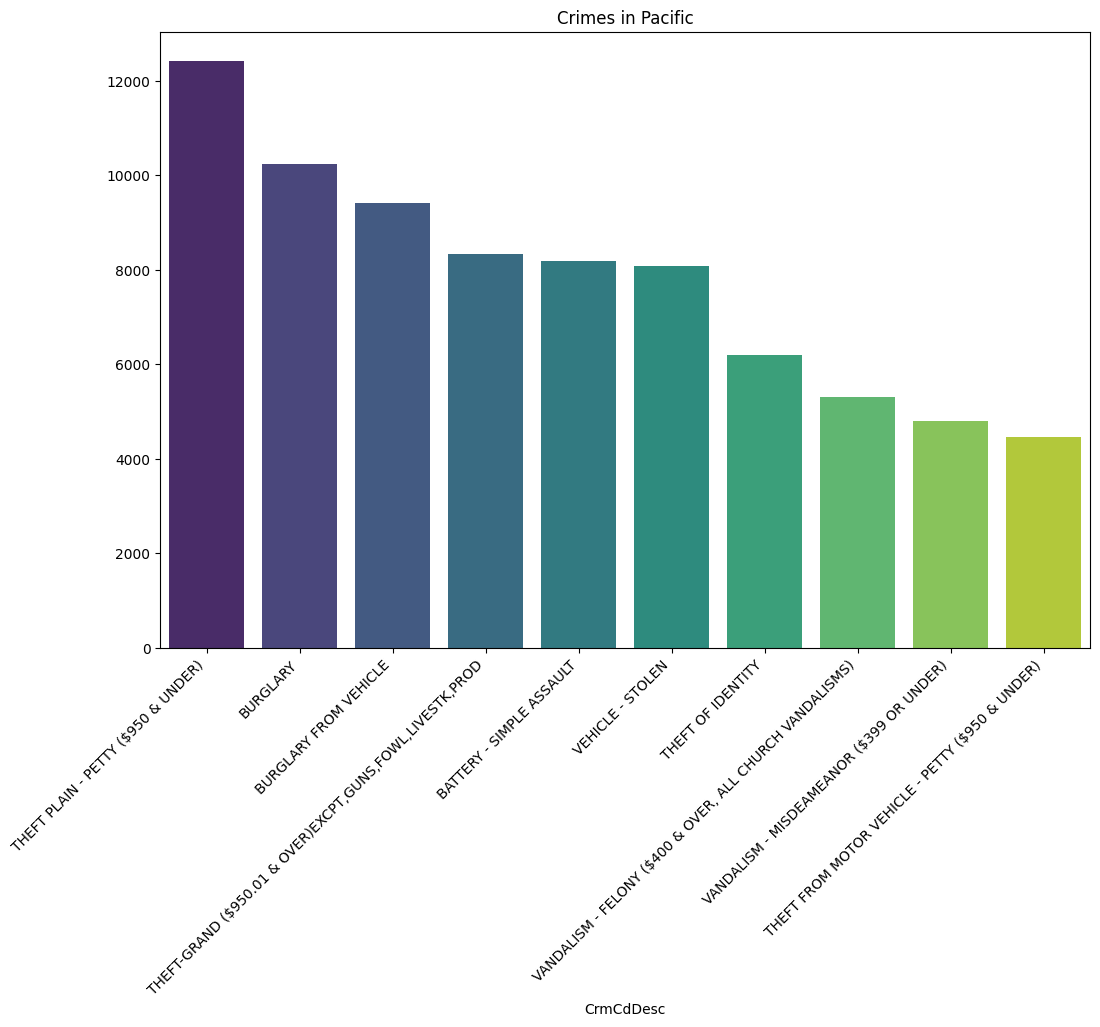

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


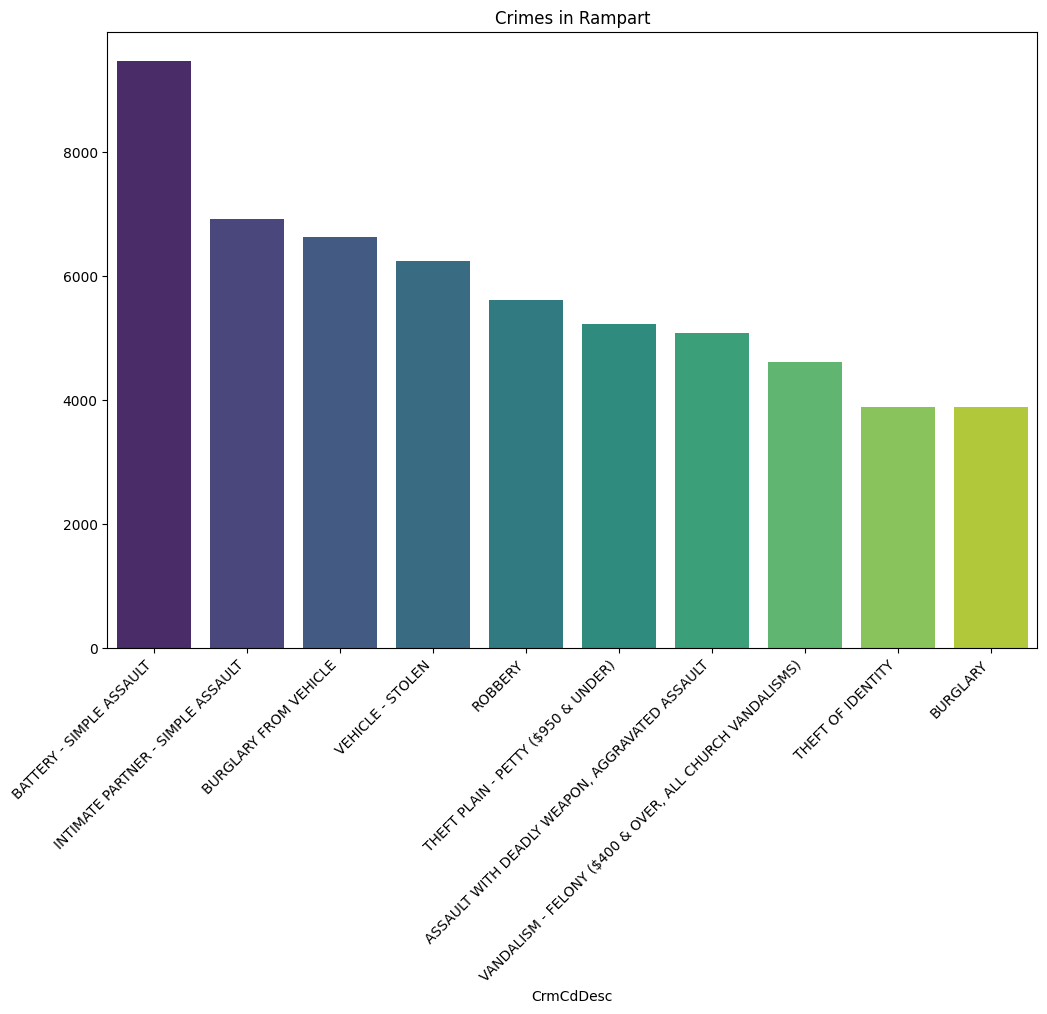

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


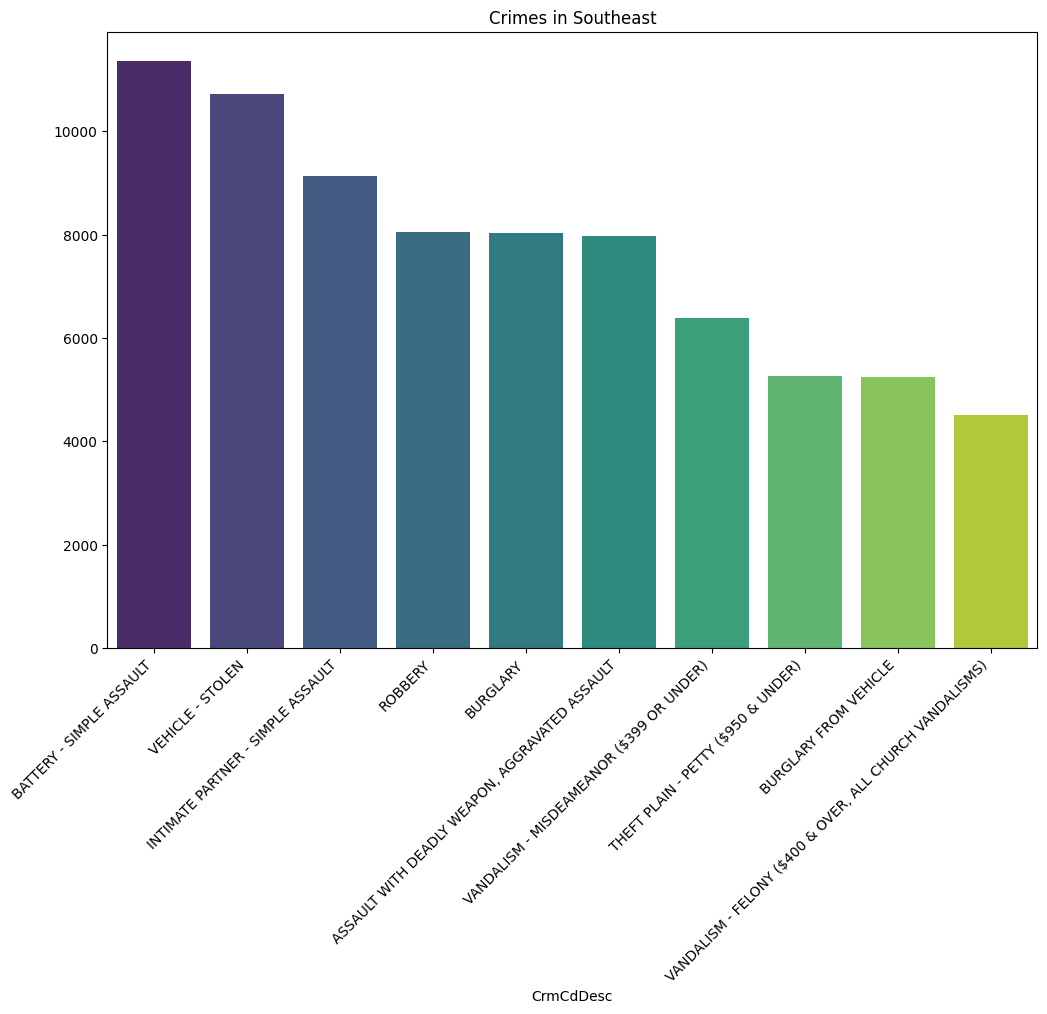

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


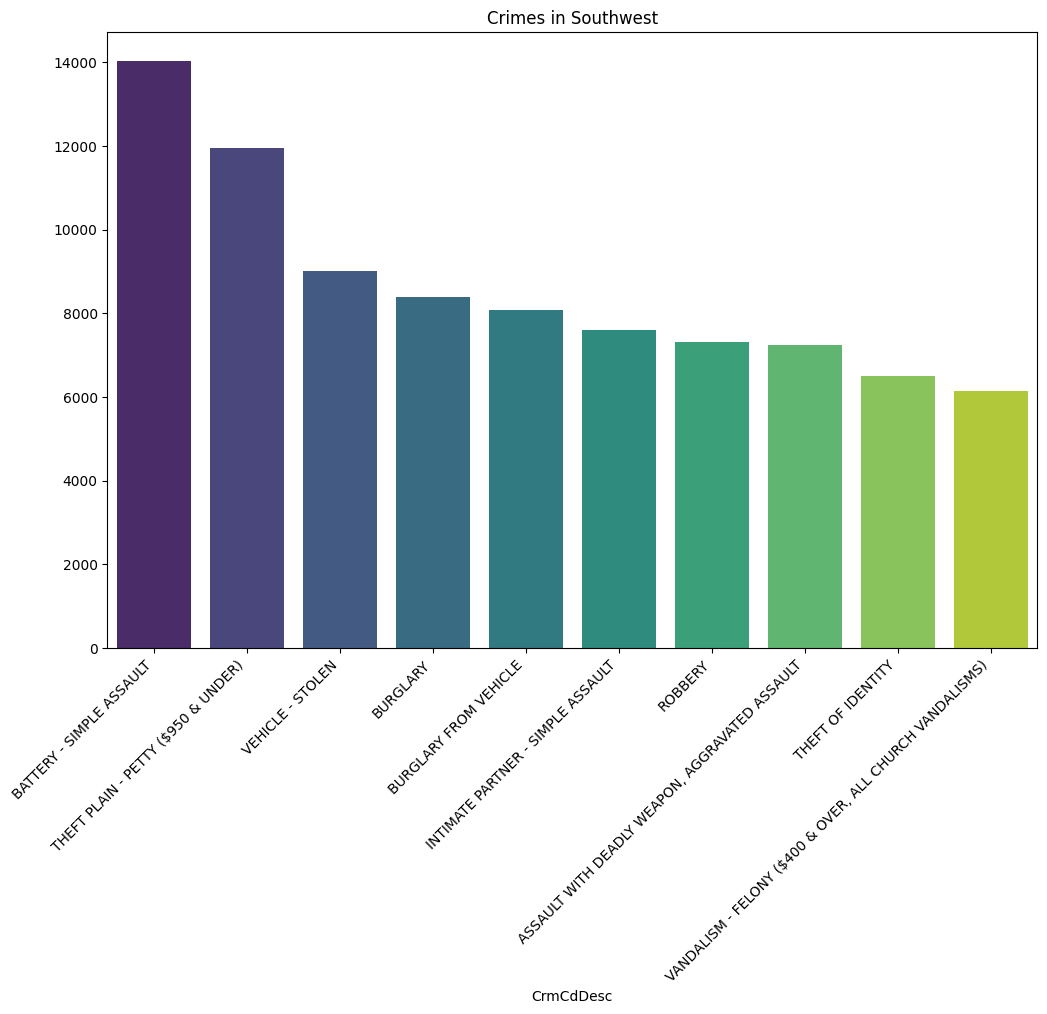

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


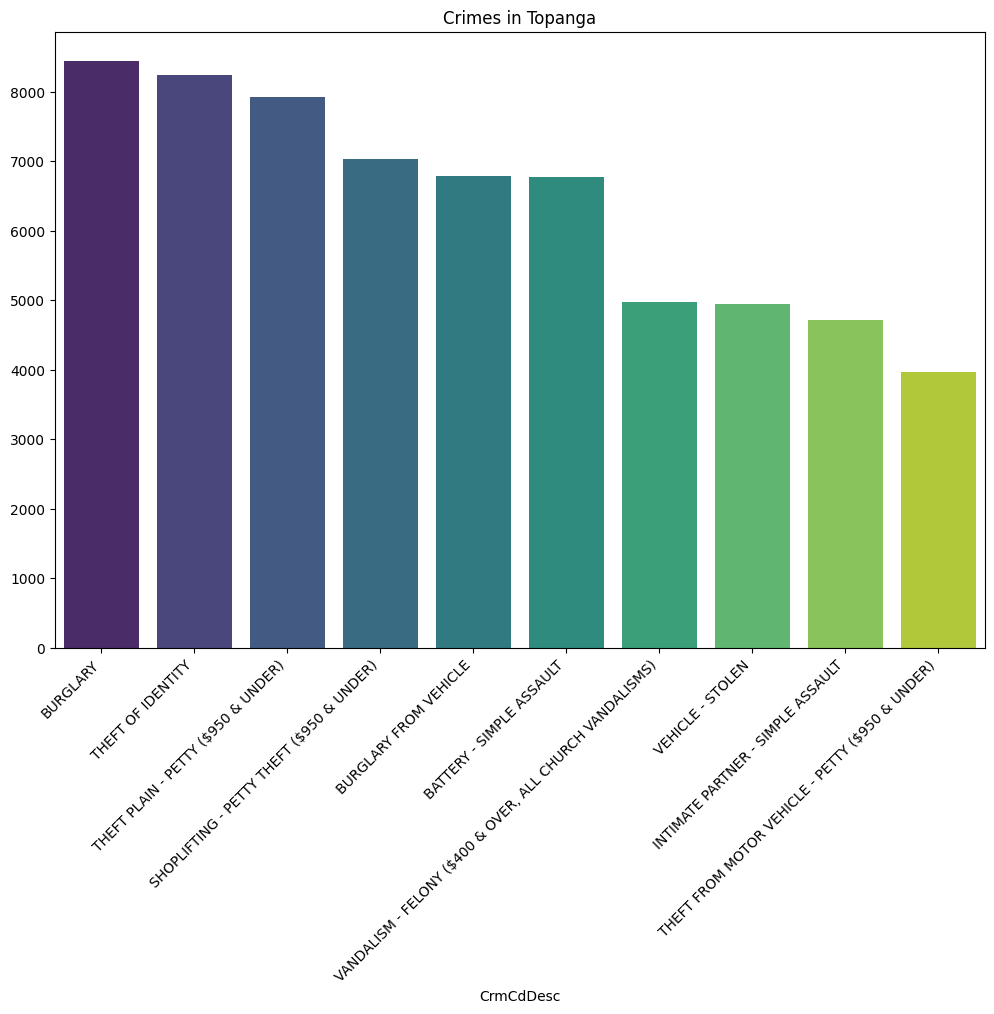

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


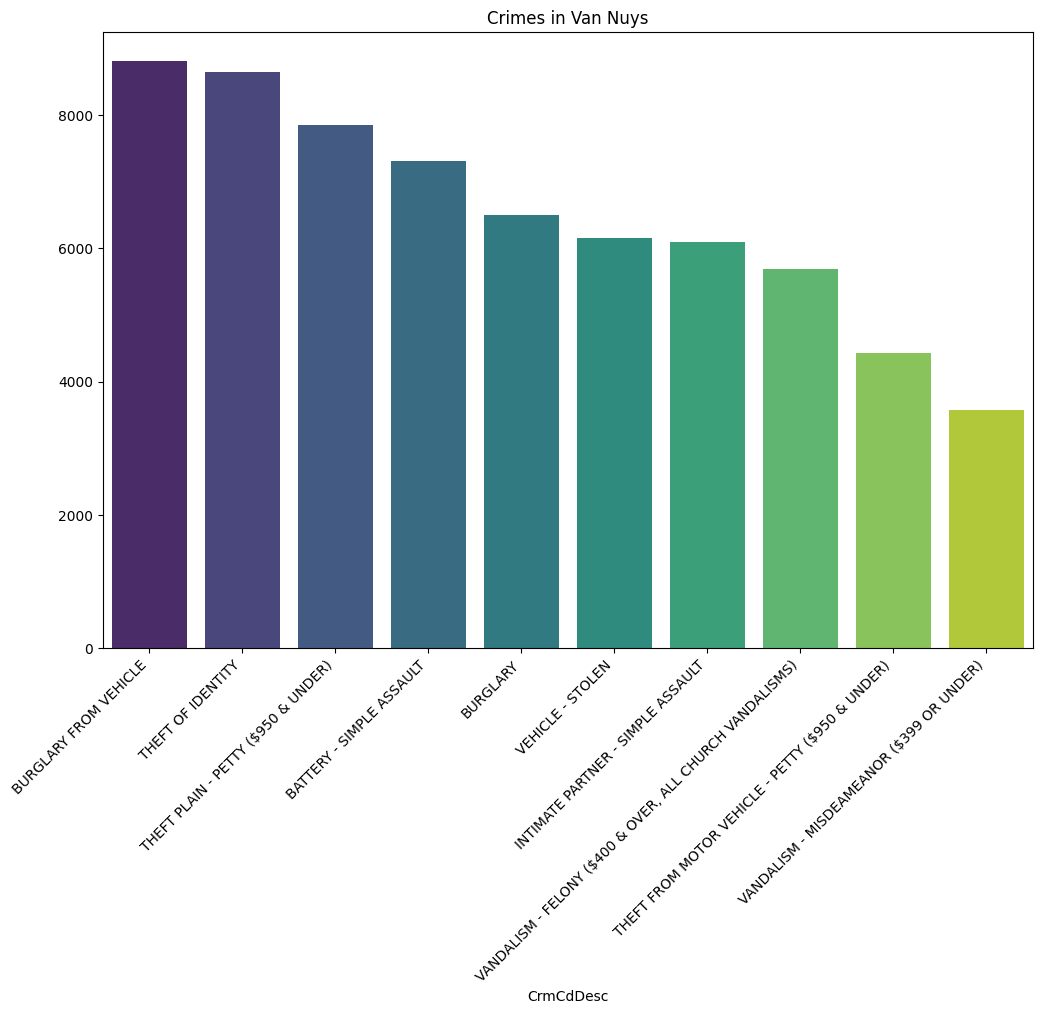

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


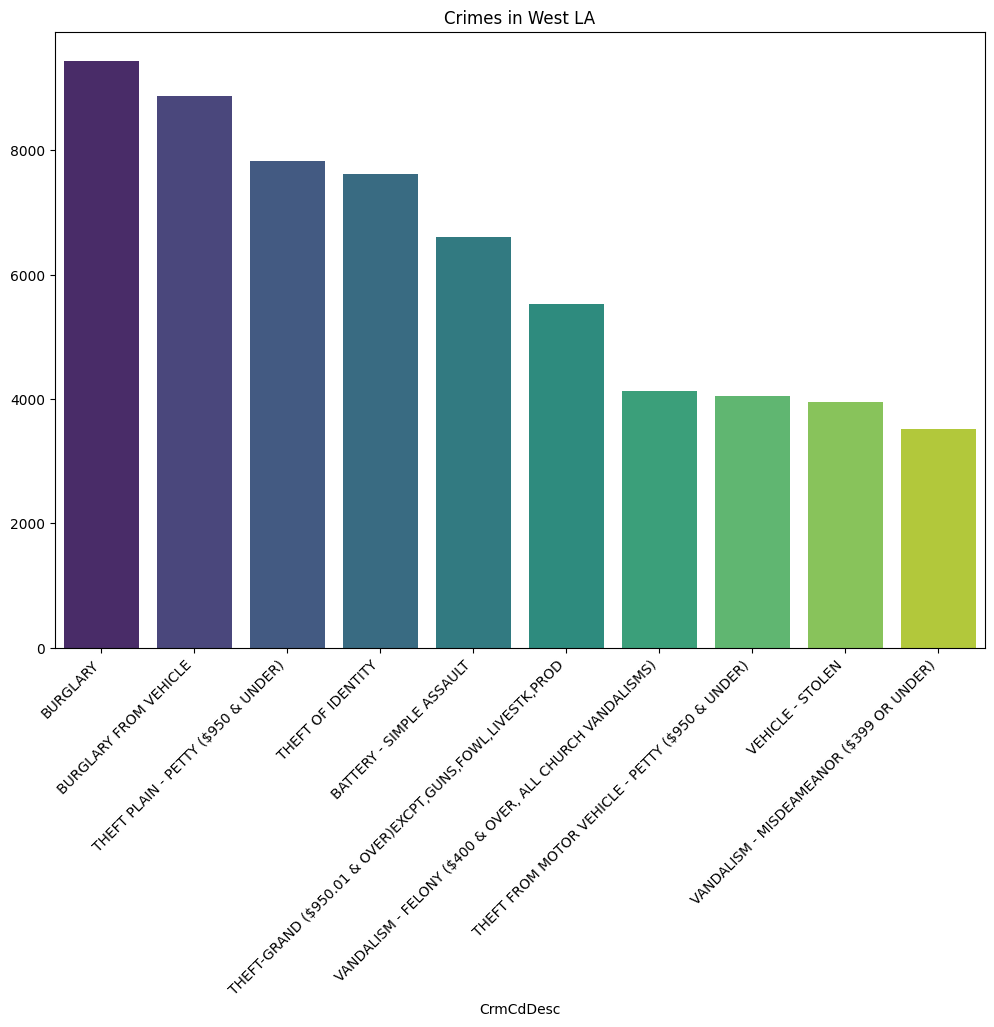

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


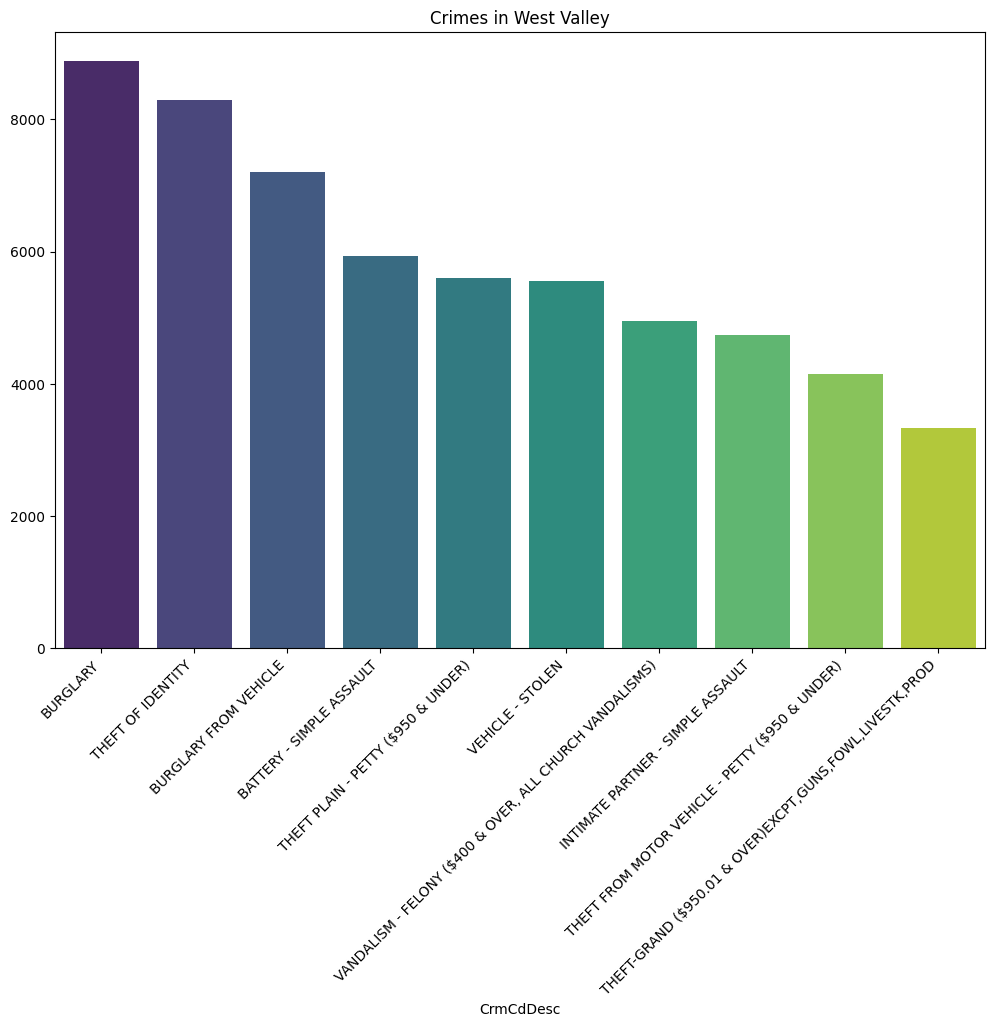

C:\Users\afons\AppData\Local\Temp\ipykernel_18388\206833550.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


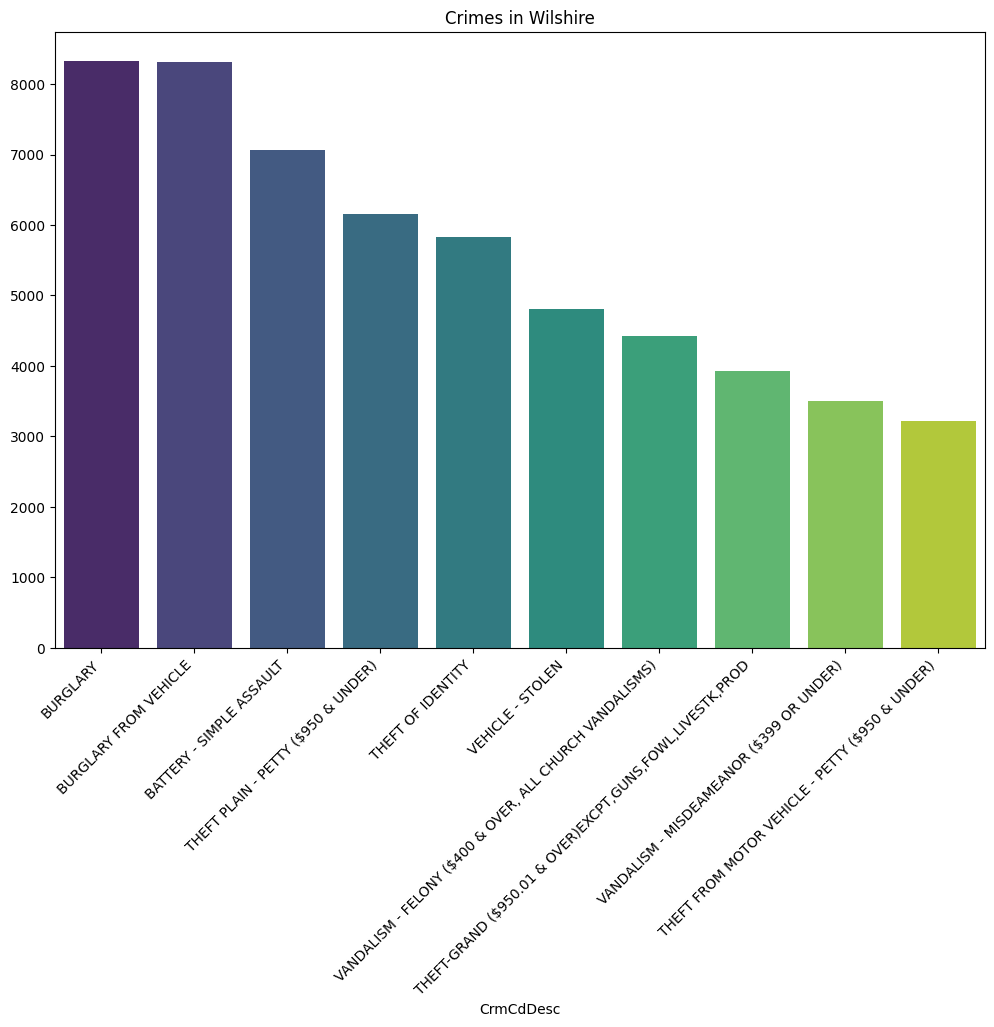

In [28]:
crimeByArea = cd['AreaName'].value_counts().sort_index()
crimeCommonType = {}

for area in crimeByArea.index:
    crimeArea = cd[cd['AreaName'] == area]['CrmCdDesc'].value_counts().nlargest(10)
    
    for crType in crimeArea.index:
        if crType not in crimeCommonType:
            crimeCommonType[crType] = [area]
        else:
            crimeCommonType[crType].append(area)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")
    plt.title("Crimes in " + area)
    plt.xticks(rotation=45, ha='right')
    plt.show()

### WHICH DAY OF THE MONTH DO THE MOST AMOUNT OF CRIMES OCCUR?

<Axes: xlabel='day', ylabel='count'>

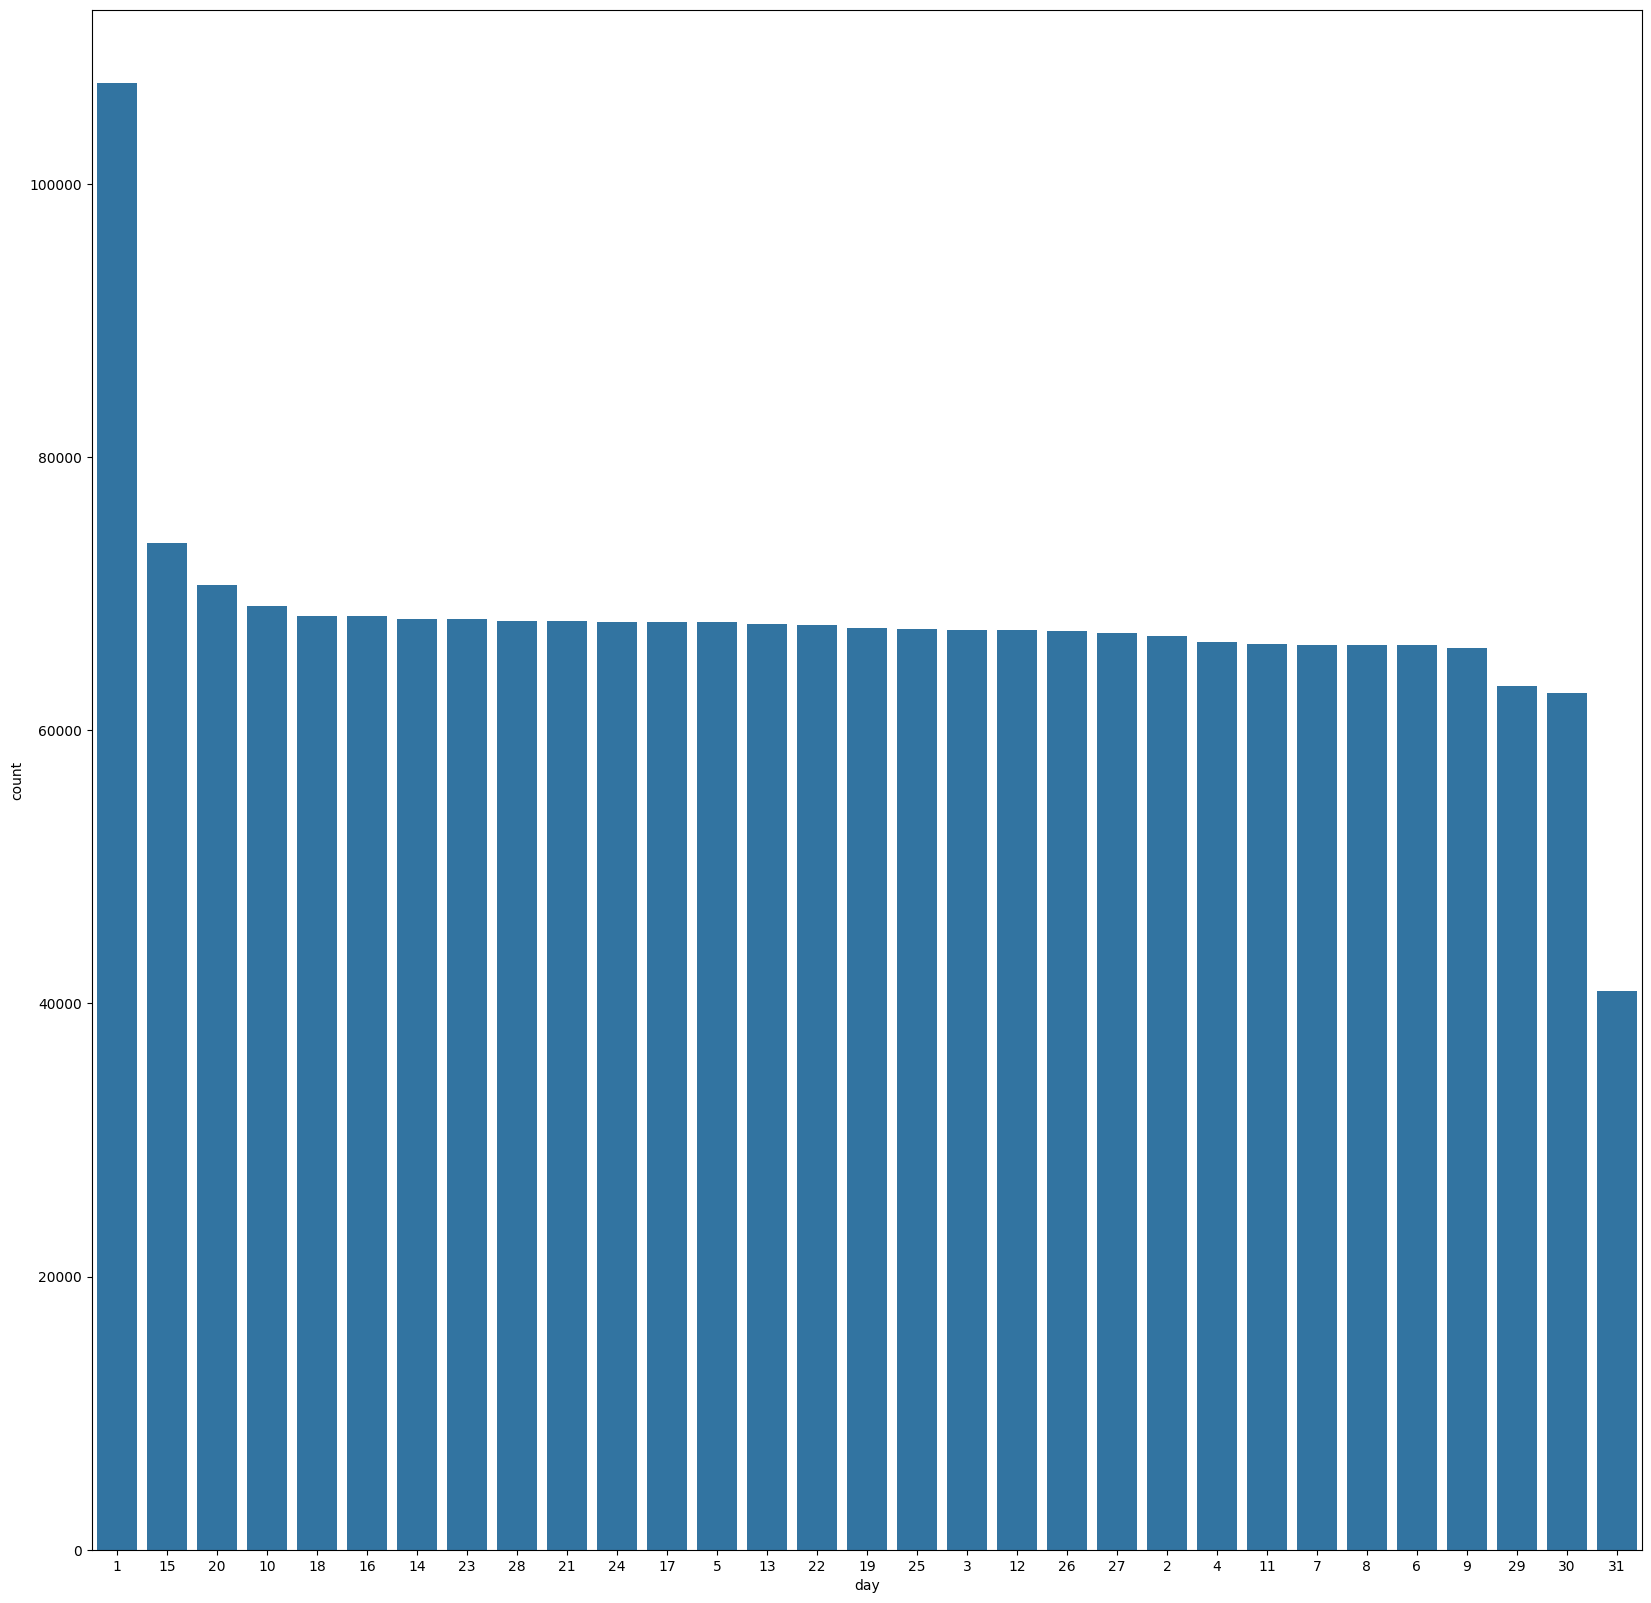

In [29]:
plt.figure(figsize=(20, 20))
sns.countplot(data=cd, x='day', order=cd['day'].value_counts().index)

The data shows that more often than not, a crime is most likely to occur in the 1st day of the month

### WHICH MONTH DID THE MOST AMOUNT OF CRIMES OCCUR?

<Axes: xlabel='month_desc', ylabel='count'>

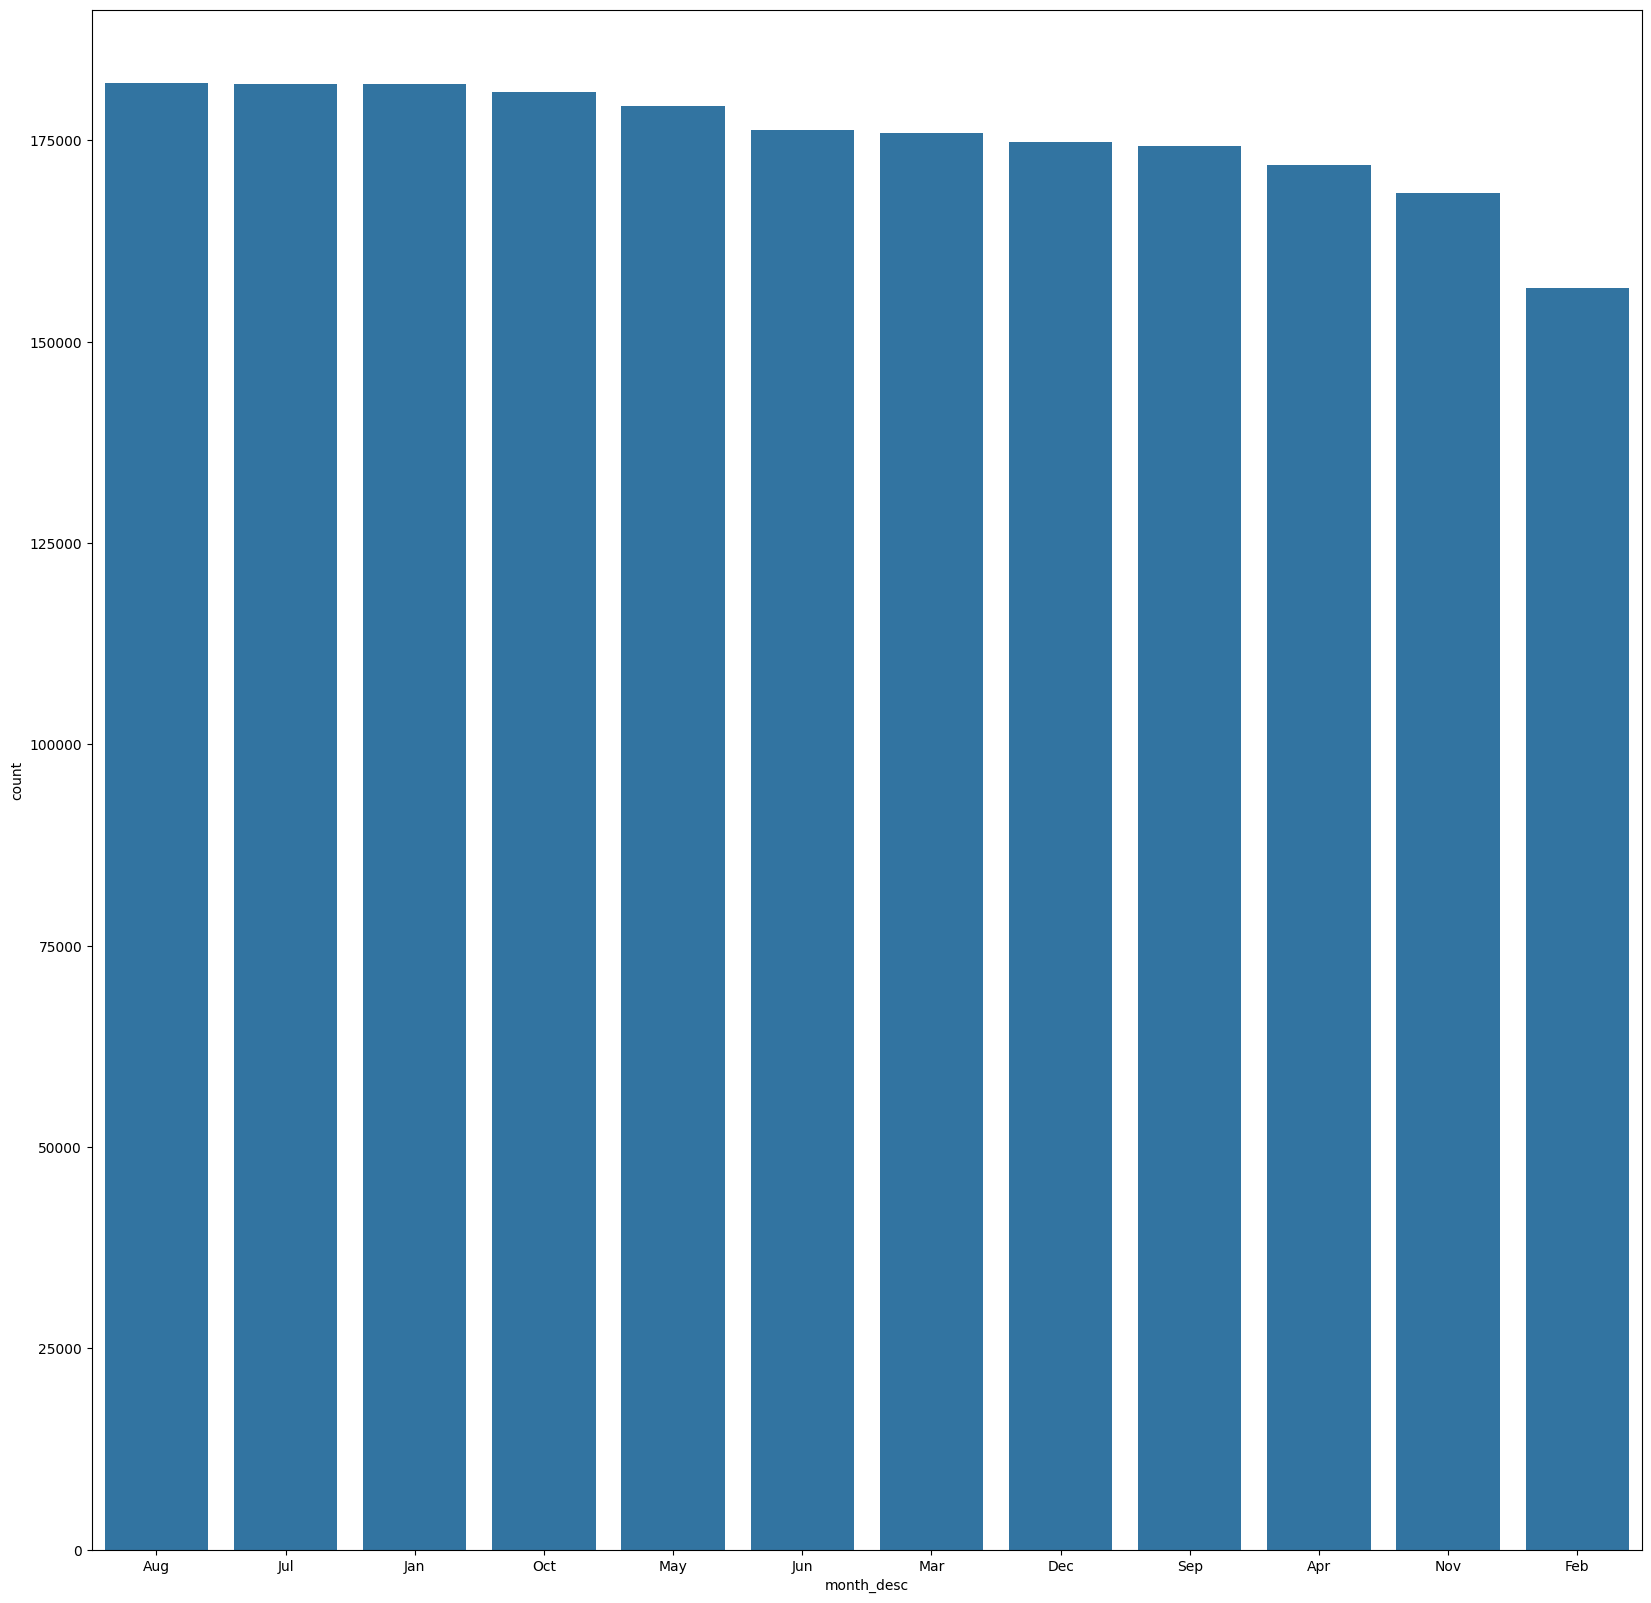

In [30]:
import calendar
cd['month_desc'] = cd['month'].map(lambda x: calendar.month_abbr[x])
plt.figure(figsize=(20, 20))
sns.countplot(data=cd, x='month_desc', order=cd['month_desc'].value_counts().index)

Interestingly, the amount of crimes is somewhat uniform throughout the year, with no particular month with an overwhelming difference to the rest

### CRIME RATE PER YEAR

year
2017    229645
2018    227542
2016    224140
2019    216042
2015    214223
2010    207710
2012    200297
2011    199287
2014    194289
2013    191481
Name: count, dtype: int64

<Figure size 2000x2000 with 0 Axes>

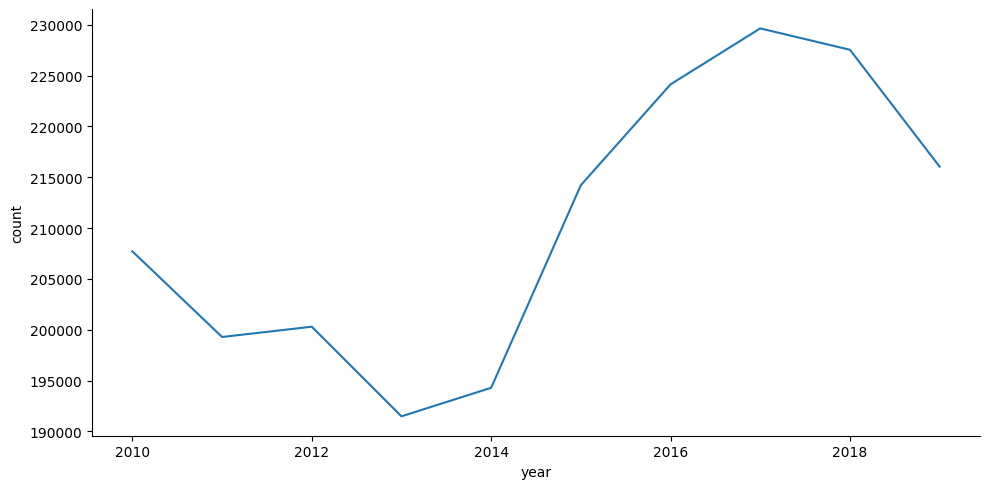

In [31]:
year_data = pd.DataFrame(cd['year'].value_counts())
year_data.rename(columns = {'year':'Count'}, inplace = True)

plt.figure(figsize=(20, 20))
sns.relplot(
    data=year_data, 
    x=year_data.index, y=cd['year'].value_counts(),
    height=5, aspect=2, 
    kind="line"
)
cd['year'].value_counts()

Since the data only goes as far as part of 2021, the discrepancy on the numbers for 2021 is justifiable. Otherwise, the 2016-2018 period saw the most amount of crime.

### VICTIM DATA

In [32]:
cd.loc[(cd["VictDescent"] == 'H'),'VictDescent']='Hispanic/Latin/Mexican'
cd.loc[(cd["VictDescent"] == 'B'),'VictDescent']='Black'
cd.loc[(cd["VictDescent"] == 'W'),'VictDescent']='White'
cd.loc[(cd["VictDescent"] == 'A'),'VictDescent']='Other Asian'
cd.loc[(cd["VictDescent"] == 'X'),'VictDescent']='Unknown'
cd.loc[(cd["VictDescent"] == 'C'),'VictDescent']='Chinese'
cd.loc[(cd["VictDescent"] == 'D'),'VictDescent']='Combodian'
cd.loc[(cd["VictDescent"] == 'F'),'VictDescent']='Filipino'
cd.loc[(cd["VictDescent"] == 'G'),'VictDescent']='Guamanian'
cd.loc[(cd["VictDescent"] == 'I'),'VictDescent']='America Indian/Alaskan Native'
cd.loc[(cd["VictDescent"] == 'J'),'VictDescent']='Japanese'
cd.loc[(cd["VictDescent"] == 'K'),'VictDescent']='Korean'
cd.loc[(cd["VictDescent"] == 'L'),'VictDescent']='Laotian'
cd.loc[(cd["VictDescent"] == 'O'),'VictDescent']='Other'
cd.loc[(cd["VictDescent"] == 'S'),'VictDescent']='Samoan'
cd.loc[(cd["VictDescent"] == 'U'),'VictDescent']='Hawaiian'
cd.loc[(cd["VictDescent"] == 'V'),'VictDescent']='Vietnamese'
cd.loc[(cd["VictDescent"] == 'Z'),'VictDescent']='Asian Indian'

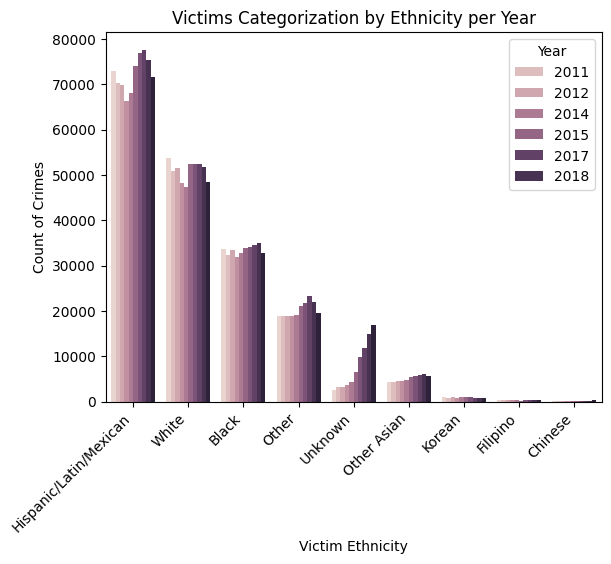

VictDescent
Hispanic/Latin/Mexican           722753
White                            509015
Black                            334098
Other                            202036
Unknown                           76689
Other Asian                       51048
Korean                             9162
Filipino                           2571
Chinese                            1069
America Indian/Alaskan Native       950
Japanese                            415
P                                   345
Vietnamese                          203
Hawaiian                            170
Asian Indian                        136
Guamanian                            85
Samoan                               29
Combodian                            24
Laotian                              18
-                                     3
Name: count, dtype: int64

In [33]:
sns.countplot(x='VictDescent', hue='year', data=cd, order=cd['VictDescent'].value_counts().index[:9])

plt.title('Victims Categorization by Ethnicity per Year')
plt.xlabel('Victim Ethnicity')
plt.ylabel('Count of Crimes')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Year')
plt.show()

cd['VictDescent'].value_counts()

From the data shown, it seems that Hispanics compose the largest portion of the number of victims, followed by white descents and then Blacks. To do a more thorough conclusion, we would need to get the demographics of LA.

### THE 10 MOST COMMITED TYPES OF CRIMES IN LA BETWEEN 2010-2021

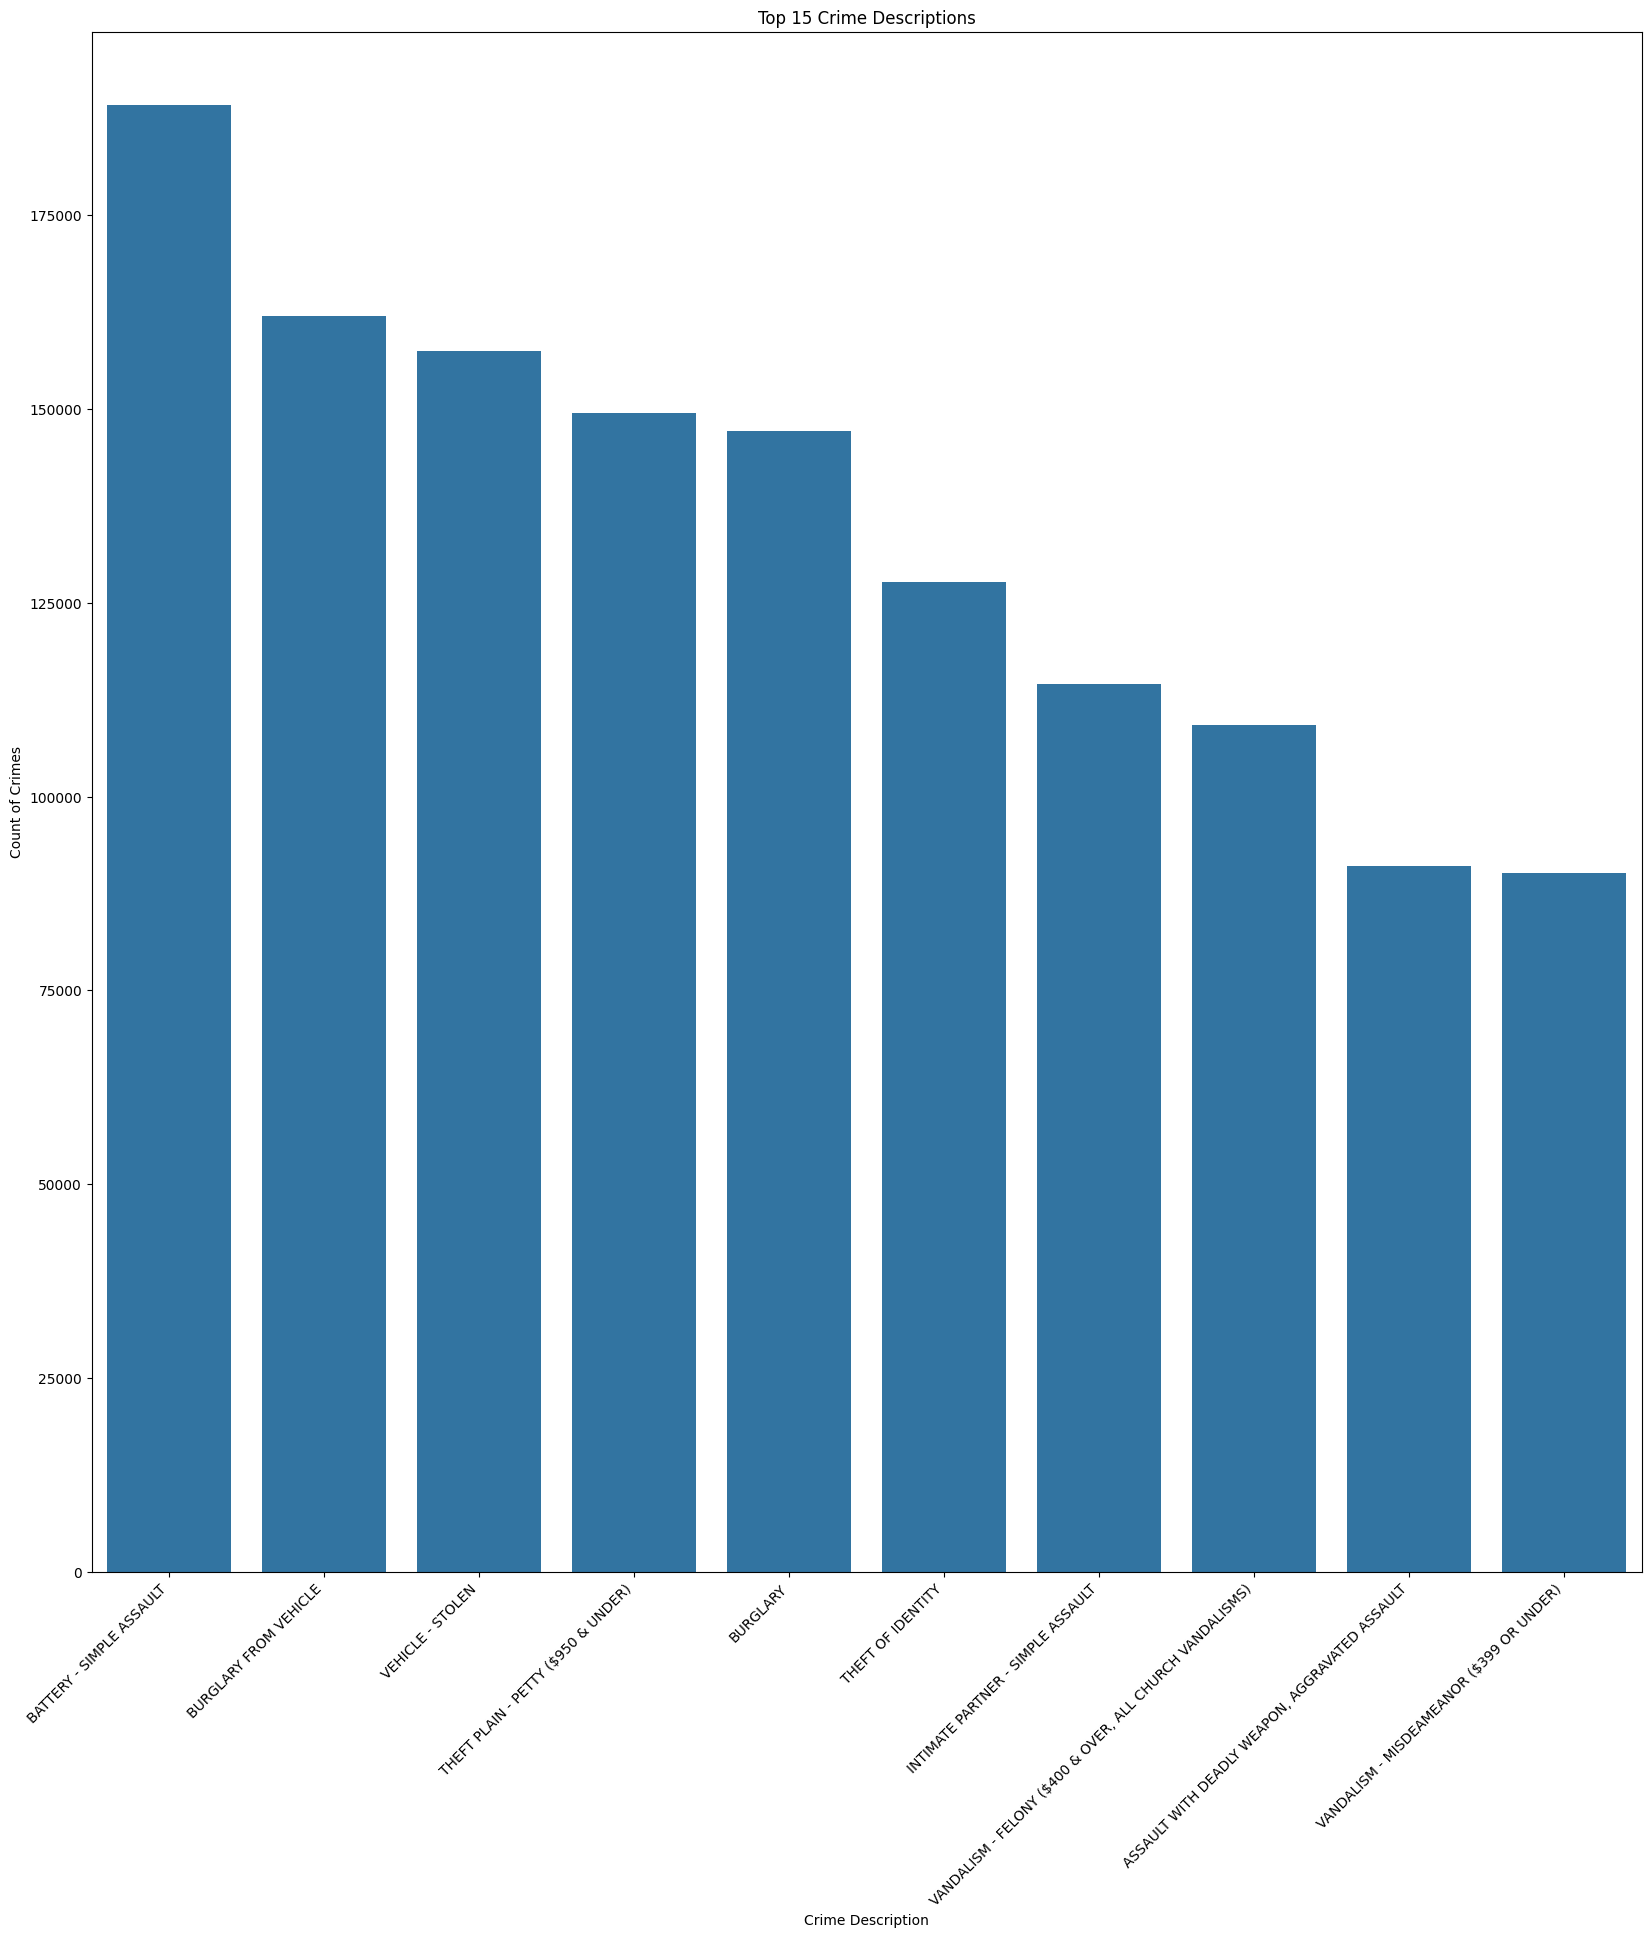

In [34]:
plt.figure(figsize=(20, 20))

sns.countplot(x='CrmCdDesc', data=cd, order=cd['CrmCdDesc'].value_counts().index[:10])

plt.title('Top 15 Crime Descriptions')
plt.xlabel('Crime Description')
plt.ylabel('Count of Crimes')

plt.xticks(rotation=45, ha='right')
plt.show()

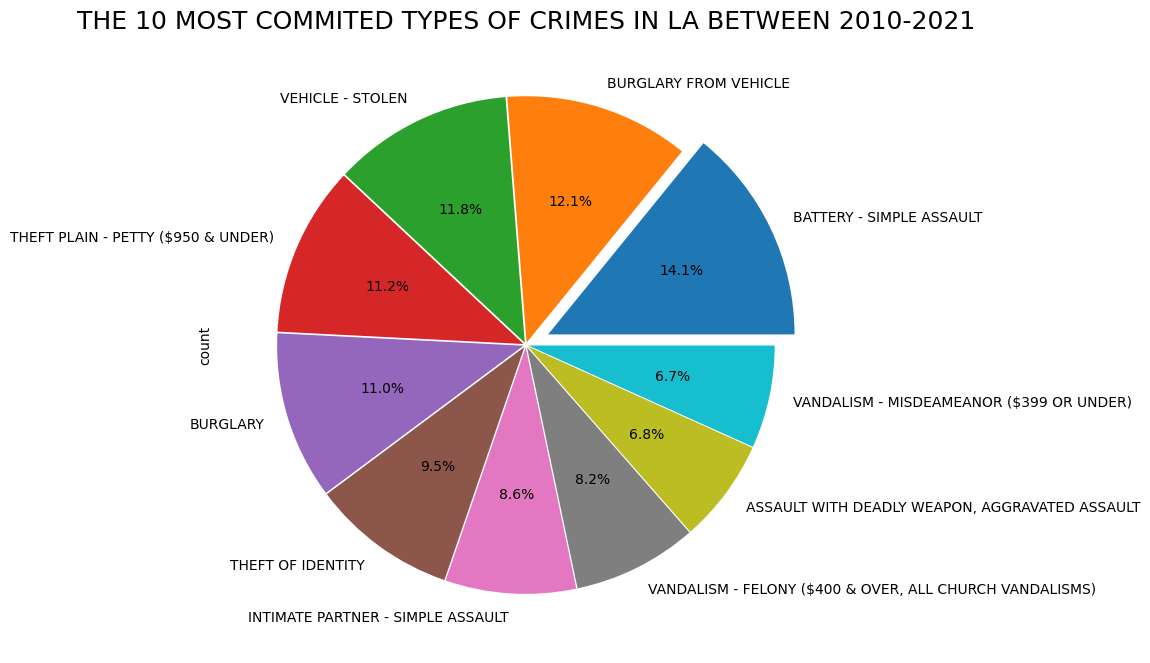

In [35]:
cd["CrmCdDesc"].value_counts()[:10].plot.pie(figsize=(12,8),explode=(0.1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01),autopct="%1.1f%%")
plt.title("THE 10 MOST COMMITED TYPES OF CRIMES IN LA BETWEEN 2010-2021",fontsize=18)
plt.show()